In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# modules

import os
import math
import numpy as np
import sympy as sym
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from imp import reload as rl
from glob import glob as glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from xml.etree import ElementTree as et
import statsmodels.formula.api as sm

# settings
## pandas
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None

## matplot
plt.rcParams['pdf.fonttype'] = 42

('15C', '20C', '25C', '35C', '45C', '50C', '55C')


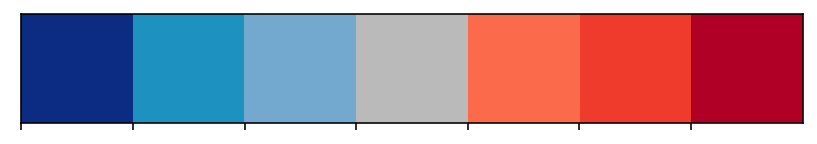

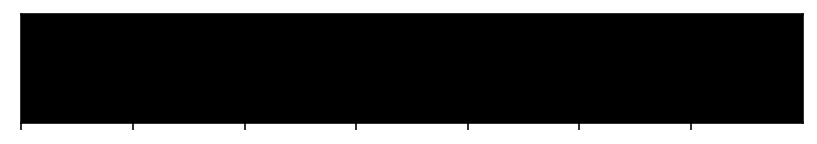

In [2]:
# choosing colors for the graphs
# colors9 = blue --> grey --> red

#temps = ('10C', '20C', '25C', '30C', '40C')
temps = ('15C','20C','25C','35C','45C','50C','55C')
print(temps)


colorset = ["#0c2c84", "#1d91c0", "#74a9cf", "#bababa", "#fb6a4a", "#ef3b2c", "#b10026"]
CS = sns.color_palette(colorset)
allblack = sns.color_palette(['black','black','black','black','black','black','black'])
allblue = sns.color_palette(['blue','blue','blue','blue','blue','blue','blue'])
allred = sns.color_palette(['red','red','red','red','red','red','red'])
allgreen = sns.color_palette(['green','green','green','green','green','green','green'])
# print colors to see:
sns.palplot(CS)
sns.palplot(allblack)

# temperature:color code for plotting:
temp2color = {temp:color for temp, color in zip(temps, CS)}
temp2colorblack = {temp:color for temp, color in zip(temps, allblack)}
temp2colorblue = {temp:color for temp, color in zip(temps, allblue)}
temp2colorred = {temp:color for temp, color in zip(temps, allred)}
temp2colorgreen = {temp:color for temp, color in zip(temps, allgreen)}

In [3]:
#generate back exchange file first from HDX Workbench XML output

files = glob('xml_BE/*.xml')
print("files is", files)

BE = []

for i in files:
    tree = et.parse(i)
    root = tree.getroot()

    df = {'start':[], 'end':[], 'charge':[], 'sequence':[], 'temperature':[], 'timepoint':[], 'replicate':[], 'percentD':[], 'valid':[]}

    for peptide in root.iter('Peptide'):
        for sample in list(peptide):
            for datapoint in list(sample):
                for rep in list(datapoint):
                    if len(peptide.attrib['start']) > 0:
                        df['start'].append(peptide.attrib['start'])
                    else:
                        df['start'].append(np.nan)
                    df['end'].append(float(peptide.attrib['end']))
                    df['charge'].append(float(peptide.attrib['charge']))
                    df['sequence'].append(peptide.attrib['sequence'])
                    df['timepoint'].append(float(datapoint.attrib['name'].strip().replace('s','')))
                    df['temperature'].append(sample.attrib['name'])
                    df['replicate'].append(rep.attrib['name'])
                    df['percentD'].append(float(rep.attrib['percentD']))
                    df['valid'].append(rep.attrib['valid'])
    BE.append(pd.DataFrame(df))

BE = pd.concat(BE)
BE['percentD_good'] = np.where(BE['valid']=='true', BE.percentD, np.NaN) 
BE['start'] = BE['start'].apply(float)
BE.sort_values(['start','end','charge','temperature','timepoint','replicate'],inplace=True)
BE.to_csv('XML_BE/BE.tsv', sep="\t")
BE

files is ['xml_BE\\BE-HDX.xml']


,start,end,charge,sequence,temperature,timepoint,replicate,percentD,valid,percentD_good
80,1.0,12.0,3.0,GGSMRSRRVDVM,L123A&WT-BE,0.0,1,0.000000,true,0.000000
81,1.0,12.0,3.0,GGSMRSRRVDVM,L123A&WT-BE,10.0,1,52.245000,true,52.245000
...,...,...,...,...,...,...,...,...,...,...
178,NaN,10.0,2.0,LLTEMSHPGAEM,L123A&WT-BE,400.0,1,50.682222,true,50.682222
179,NaN,10.0,2.0,LLTEMSHPGAEM,L123A&WT-BE,500.0,1,51.622222,true,51.622222


In [4]:
## Anish's additions -- prune the HDX data to only get important BE samples, followed by removing 0 timepoint, and then merging
#i = ('xml_BE\\peptides_pruned.csv')
i = ('xml_BE/peptides_pruned.csv')
#HDX_tsv = ('xml_BE\\BE.tsv')
HDX_tsv = ('xml_BE/BE.tsv')
peptides = pd.DataFrame(pd.read_csv(i, sep=','))
BE_data = pd.DataFrame(pd.read_csv(HDX_tsv, sep='\t'))
new_data = pd.merge(left=BE_data, right = peptides[['start','end']] , on = ['start','end'])
new_data_nozerotp = new_data[new_data.timepoint!=0]
percentD=new_data_nozerotp.groupby(['start','end','sequence'], as_index=False)['percentD_good'].mean()
data_withoutpercentD=new_data_nozerotp.drop(columns=['percentD_good'])
data = pd.merge(left=data_withoutpercentD, right=percentD, on = ['start','end','sequence'] )
data = data.rename(columns={"percentD_good":"BE"})
subset = data[['start','end','charge','BE']]
subset=subset.drop_duplicates()
print(subset)
#for e, ee in (new_data.groupby(by=['start','end','sequence'])):
#    print ('e is', e)
#    print ('ee is', ee)
subset.to_csv('XML_BE/BE_curate.tsv', sep="\t")


     start    end  charge         BE
0      1.0   12.0     3.0  50.257500
9     13.0   20.0     2.0  45.431667
..     ...    ...     ...        ...
288  208.0  223.0     2.0  77.074615
306  224.0  231.0     2.0  80.907000

[25 rows x 4 columns]


In [5]:
# curate BE.tsv file to only contain designated peptide set.
# Further datasets will be reduced to only contain peptides in the BE_df 

BE_df = pd.DataFrame(pd.read_csv('XML_BE/BE_curate.tsv', sep='\t'))
BE_df['start'] = BE_df['start'].apply(float)
BE_df['charge'] = BE_df['charge'].apply(float)
BE_df['end'] = BE_df['end'].apply(float)
BE_df

,Unnamed: 0,start,end,charge,BE
0,0,1.0,12.0,3.0,50.257500
1,9,13.0,20.0,2.0,45.431667
...,...,...,...,...,...
23,288,208.0,223.0,2.0,77.074615
24,306,224.0,231.0,2.0,80.907000


In [6]:
# Upload all temperature dependent HDX-MS data from XML files and tabulate into dataframe
# percentD_good reports on the HDX Workbench value that can be toggled to include or not include a data point

files = glob('xml_data/*.xml')

WT = []

for i in files:
    tree = et.parse(i)
    root = tree.getroot()
    temperature = i.split(".")[0].split("-")[1].split("_")[0]
    
    new_temp = temperature
    rep_act = i.split(".")[0].split("-")[1].split("_")[1]
    
    df = {'start':[], 'end':[], 'charge':[], 'sequence':[], 'temperature':[], 'timepoint':[], 'replicate':[], 'percentD':[], 'valid':[]}

    for peptide in root.iter('Peptide'):
        for sample in list(peptide):
            for datapoint in list(sample):
                for rep in list(datapoint):
                    if len(peptide.attrib['start']) > 0:
                        df['start'].append(peptide.attrib['start'])
                    else:
                        df['start'].append(np.nan)
                    df['end'].append(float(peptide.attrib['end']))
                    df['charge'].append(float(peptide.attrib['charge']))
                    df['sequence'].append(peptide.attrib['sequence'])
                    df['timepoint'].append(float(datapoint.attrib['name'].strip().replace('s','')))
                    #df['temperature'].append(sample.attrib['name'])
                    df['temperature'].append(new_temp)
                    df['replicate'].append(rep_act)
                    df['percentD'].append(float(rep.attrib['percentD']))
                    df['valid'].append(rep.attrib['valid'])
    WT.append(pd.DataFrame(df))

WT = pd.concat(WT)
WT['percentD_good'] = np.where(WT['valid']=='true', WT.percentD, np.NaN) 
WT['start'] = WT['start'].apply(float)
WT.to_csv('WT.percentD.tsv', sep="\t")




#BE.to_csv('XML_BE/BE.tsv', sep="\t")

In [7]:
# Merge BE and WT dataframes such that only peptides in the BE dataframe are used for further analysis
# converting time point data from seconds into minutes


merged = {}
merged = pd.merge(left=BE_df, right=WT, on=['start', 'end', 'charge'])
print(merged)
merged['percentD_corr']=merged['percentD_good']*100/merged['BE']
merged['timepoint']=merged['timepoint'].astype(np.int64)
merged['replicate']=merged['replicate'].astype(np.int64)
merged['timepoint'] = (merged['timepoint'])/60
merged['AAs']=merged['sequence'].str.len()
merged['#P']=merged['sequence'].str.count('P')
merged['NH-total']=merged['AAs']-merged['#P']-2
merged['Daltons']=merged['percentD_corr']/100*merged['NH-total']
merged.sort_values(['start','end','charge','temperature','timepoint','replicate'],inplace=True)

merged.to_csv('merged.tsv', sep="\t")


      Unnamed: 0  start    end  charge       BE      sequence temperature  \
0              0    1.0   12.0     3.0  50.2575  GGSMRSRRVDVM         15C   
1              0    1.0   12.0     3.0  50.2575  GGSMRSRRVDVM         15C   
...          ...    ...    ...     ...      ...           ...         ...   
5248         306  224.0  231.0     2.0  80.9070      SIKDLLNP         55C   
5249         306  224.0  231.0     2.0  80.9070      SIKDLLNP         55C   

      timepoint replicate   percentD valid  percentD_good  
0           0.0         1   0.000000  true       0.000000  
1          10.0         1  32.813333  true      32.813333  
...         ...       ...        ...   ...            ...  
5248    10800.0         2  82.960000  true      82.960000  
5249    14400.0         2  82.528889  true      82.528889  

[5250 rows x 12 columns]


In [8]:
#calculate average and standard deviation of replicate data

merged2 ={}
merged2['start'] = []
merged2['end'] = []
merged2['charge'] = []
merged2['temperature'] = []
merged2['timepoint'] = []
merged2['avg'] = []
merged2['sd'] = []
    
esubs = ['charge', 'start', 'end', 'temperature', 'timepoint']
for e, ee in merged.groupby(by = esubs):
    avgv = ee['Daltons'].mean()
    stdv = ee['Daltons'].std()
    merged2['avg'].append(avgv)
    merged2['sd'].append(stdv)
    merged2['start'].append(ee['start'].iloc[0])
    merged2['end'].append(ee['end'].iloc[0])
    merged2['charge'].append(ee['charge'].iloc[0])
    merged2['temperature'].append(ee['temperature'].iloc[0])
    merged2['timepoint'].append(ee['timepoint'].iloc[0])
merged2 = pd.DataFrame(merged2)
merged2

mergedc = pd.merge(merged, merged2, how = 'outer', on = ['timepoint', 'charge', 'start', 'end', 'temperature'])
mergedc.to_csv('merged2.tsv', sep="\t")

In [9]:
#make a new column for the max exchange value (NH_exchange_max) for each unique dataset - this value will be used in the fitting

merged3 = {}
merged3['NH_exchange_max'] = []
merged3['start'] = []
merged3['end'] = []
merged3['charge'] = []
merged3['temperature'] = []
substt = ['charge', 'start', 'end', 'temperature']
for add, adds in mergedc.groupby(by = substt):
    tt = adds['avg'].max()
    merged3['NH_exchange_max'].append(tt)
    
    merged3['start'].append(adds['start'].iloc[0])
    merged3['end'].append(adds['end'].iloc[0])
    merged3['charge'].append(adds['charge'].iloc[0])
    merged3['temperature'].append(adds['temperature'].iloc[0])
merged3 = pd.DataFrame(merged3)


WTmerged = pd.merge(mergedc, merged3, 
               how = 'outer', 
               on = ['charge', 'start', 'end', 'temperature'])

WTmerged.to_csv('WTmerged.tsv', sep="\t")
WTmerged

,Unnamed: 0,start,end,charge,BE,sequence,temperature,timepoint,replicate,percentD,valid,percentD_good,percentD_corr,AAs,#P,NH-total,Daltons,avg,sd,NH_exchange_max
0,0,1.0,12.0,3.0,50.2575,GGSMRSRRVDVM,15C,0.0,1,0.000000,true,0.000000,0.000000,12,0,10,0.000000,0.000000,0.000000,9.960371
1,0,1.0,12.0,3.0,50.2575,GGSMRSRRVDVM,15C,0.0,2,0.000000,true,0.000000,0.000000,12,0,10,0.000000,0.000000,0.000000,9.960371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,306,224.0,231.0,2.0,80.9070,SIKDLLNP,55C,240.0,1,76.786667,true,76.786667,94.907322,8,1,5,4.745366,4.922799,0.250928,5.028132
5249,306,224.0,231.0,2.0,80.9070,SIKDLLNP,55C,240.0,2,82.528889,true,82.528889,102.004634,8,1,5,5.100232,4.922799,0.250928,5.028132


In [10]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))
    
    c = -b*1.987
    print('activation energy is {:.2f} kcal/mol'.format(c))
    return a, b

a 1


In [11]:
# define equation for fitting (Exp3a) 
# define fitting and plotting parameters: plot errorbars based on SD, use plot(moreX...) to make a smooth line, return statement 'no fit' if data cannot be fit to the equation
# define bounds and initial values when plotting

def Exp3a(x, a, b, c, d, e, f, g):
    return g-a*(np.exp(-d*x))-b*(np.exp(-e*x))-c*(np.exp(-f*x))

def plotfit(df, x, y, yerr, hue, func, colors, p0, bounds):
    for category, subset in df.groupby(by = [hue]):
        X = subset[x].values
        Y = subset[y].values
        YR = subset[yerr].values
        try:
            popt, pcov = curve_fit(func, X, Y, p0=p0, bounds=bbounds)
            
            print ("values are A: ", popt[0], "; B: ", popt[1], "; C: ", popt[2], "; k1: ", popt[3], "; k2: ", popt[4], "; k3: ", popt[5], "; total: ", popt[6])
            #popt, pcov = curve_fit(func, X, Y, p0=pinitial)
            moreX = np.arange(int(min(X)), int(max(X)), 0.001)       
            plt.plot(moreX, func(moreX, *popt),
                     label = ('T = %s' % 
                              (tempInfo[2])), 
                     color = colors[category])
            plt.errorbar(X, Y, YR, fmt = 'none', ecolor='gray', elinewidth=1, capsize=3)
            plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
            sns.scatterplot(data = upepDF, 
                    x = 'timepoint', y = 'avg', hue = 'temperature', 
                    palette = temp2color, legend = False)
            # k2 & k3
            return (math.log((popt[4]*popt[1]+popt[5]*popt[2])))
          # k2
            #return (math.log((popt[4])))
       #k1 & k2 & k3
            #return (math.log((popt[4]*popt[1]+popt[5]*popt[2]+popt[3]*popt[0])))
         # k1 & k2   
            #return (math.log((popt[3]*popt[0])))
          # k3  
            #return (math.log((popt[5]*popt[2])))
                #Ea1_temp = linfit(setDF, x = '1000/T (K)', y = 'ln(p2*k2+p3*k3)_NHobs', color = 'black')

        except RuntimeError:
                print('no fit') 

  0%|          | 0/1 [00:00<?, ?it/s]

15C
values are A:  1.6217487956445855 ; B:  1.6601471847460536 ; C:  10.714258265688521 ; k1:  15.113568521766542 ; k2:  0.009731996877305615 ; k3:  0.00013851581719803474 ; total:  13.995843689416569
20C
values are A:  1.5797606766109868 ; B:  0.37599011264599597 ; C:  3.232151351926959 ; k1:  99.99999999999999 ; k2:  0.07777162229481464 ; k3:  0.004999999999999997 ; total:  5.187902141583104
25C
values are A:  1.5493138162122966 ; B:  1.3507553618043906 ; C:  4.319623079919015 ; k1:  99.99999999999999 ; k2:  0.02811834527102022 ; k3:  0.0024439565706015466 ; total:  7.219692260228772
35C
values are A:  1.6951734091601336 ; B:  2.330555764769446 ; C:  9.974127680430461 ; k1:  16.877665890287943 ; k2:  0.0492834482185346 ; k3:  0.0010723753472509146 ; total:  13.999999999995552
45C
values are A:  1.7769309778395201 ; B:  2.8241982027667825 ; C:  5.392764260410612 ; k1:  9.27140998262476 ; k2:  0.09820053954114262 ; k3:  0.004736517396206364 ; total:  9.997338580108565
50C
values are A:

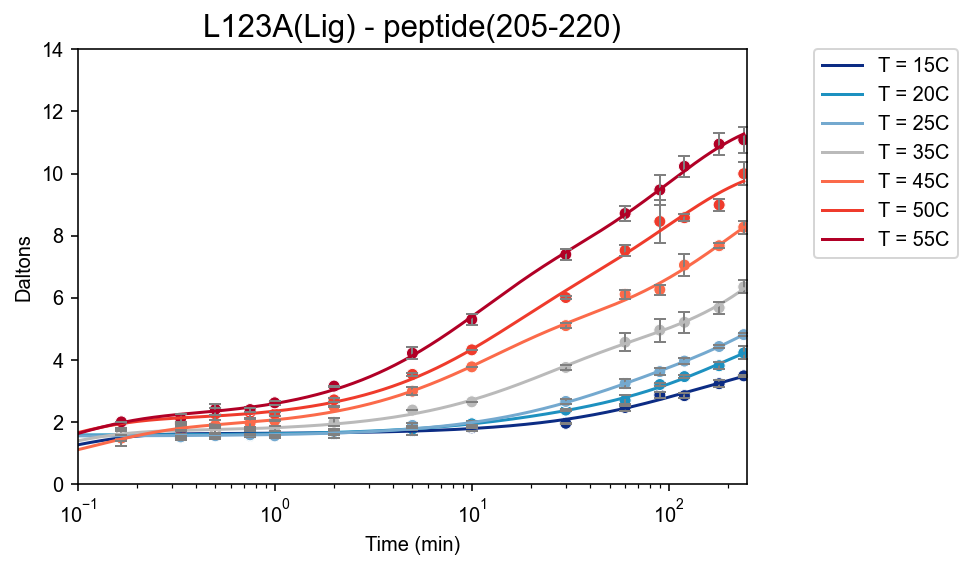

100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


In [12]:
'''
Plot as Semi-log
fitting to 3 exponentials
''' 

#bound_data=pd.DataFrame(pd.read_csv("parameters_hdx.csv"))
bound_data=pd.DataFrame(pd.read_csv("parameters_hdx_3b1.csv"))
#combining with csv with specified initial values and bounds
#WT_bounds = pd.merge(WTmerged, bound_data, how='outer', on=['start','end'])
WT_bounds=  pd.merge(WTmerged, bound_data, how='outer', on=['start','end', 'charge', 'temperature'])
#SPECIFY TEMP AS WT-15C

##I commented this out, but you can utilize this to TRY different selectors


WT_bounds=WT_bounds.loc[WTmerged["start"]==208]
WT_bounds=WT_bounds.loc[WTmerged["end"]==223]
WT_bounds=WT_bounds.loc[WTmerged["charge"]==+2]



groups2 = WT_bounds.groupby(by = ['start', 'end', 'charge', 'sequence','NH-total'], as_index = False)
num_groups = len(groups2)

#groups2 = WT_bounds.groupby(by = ['start', 'end', 'charge','temperature', 'sequence','NH-total'], as_index = False)
#num_groups = len(groups2)


for upep, upepDF in tqdm(groups2, total = num_groups):
    upepDF = upepDF.dropna(subset = ['avg'])
    ylim = upepDF['NH-total'].iloc[0]+1
    xval = [1000/288.15, 1000/293.15, 1000/298.15, 1000/308.15, 1000/318.15, 1000/323.15, 1000/328.15]
    yval = []
    for tempInfo, tempDF in upepDF.groupby(by = ['start', 'end', 'temperature']):
        start, end, temperature = tempInfo
        print(temperature)
        Nobs = tempDF['NH_exchange_max'].iloc[0]
        Ntot = tempDF['NH-total'].iloc[0]
        Ai=tempDF['a_initial'].iloc[0]
        Bi=tempDF['b_initial'].iloc[0]
        Ci=tempDF['c_initial'].iloc[0]
        k1i=tempDF['k1_initial'].iloc[0]
        k2i=tempDF['k2_initial'].iloc[0]
        k3i=tempDF['k3_initial'].iloc[0]
        NHi=tempDF['Ntotal_initial'].iloc[0]
        NHcap=tempDF['Ntotal_cap'].iloc[0]
        a_bound =tempDF['k1_cap'].iloc[0]
        b_bound =tempDF['k2_cap'].iloc[0]
        NHlow = tempDF['Ntotal_low'].iloc[0]
       # k1upper = tempDF['k1_up'].iloc[0]
        #new_variable=tempDF['name'].iloc[0]
        #Bi=
        #Ci=
        #a_bound = .3
        
        if Nobs == 0:
            Nobs = 0.1
        #pinitial = Ntot*0.25, Ntot*0.25, Ntot*0.25, 20, 0.1, 0.01, Ntot*0.25
        #bbounds = ([0,0,0,0,0.0,0,0],[Ntot*1.0,Ntot*1.0,Ntot*1.0,100,10,1,Ntot*1.1])
        #k2i=.025
        pinitial = Ai, Bi, Ci, k1i, k2i, k3i, NHi
        #pinitial = [1,1,8,15,.1,.004,10]
        #a_bound = .03
        #b_bound=.1
        bbounds = ([0,0,0,a_bound,b_bound,0,NHlow],[Ntot*1.1,Ntot*1.1,Ntot*1.1,100,a_bound,b_bound,NHcap])
       # bbounds = ([0,0,0,0,0,0,NHlow],[Ntot*1.1,Ntot*1.1,Ntot*1.1,100,10,1,Ntot*1.1])
        #bbounds = ([0,0,0,a_bound,0,0,NHlow],[Ntot*1.1,Ntot*1.1,Ntot*1.1,50,a_bound,b_bound,NHcap])
        #bbounds = ([0,0,0,2,b_bound,0,Nobs*0.9],[Ntot*1.1,Ntot*1.1,Ntot*1.1,100,2,b_bound,NHcap])
        
        #pinitial = Nobs*0.25, Nobs*0.25, Nobs*0.25, 50, 0.5, 0.0025, Nobs
        #bbounds = ([0,0,0,10,0.05,0,Nobs*0.9],[Nobs*1.1,Nobs*1.1,Nobs*1.1,1000,10,0.05,Nobs*1.1])
    

        y_int = plotfit(tempDF, x = 'timepoint', y = 'avg', yerr = 'sd', hue = 'temperature',
                func = Exp3a, colors = temp2color, 
                p0 = pinitial, 
                bounds = bbounds) 
        yval.append(y_int)
        
    
    plt.xlabel('Time (min)')
    plt.ylabel('Daltons')
    plt.xscale('log')
    plt.ylim(0, ylim)
    plt.xlim(0.1, 250)
    
#    sns.despine()
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2})
    figname = 'SemiLog_3/%s-%s_c+%s.png' % (int(upep[0]), int(upep[1]), int(upep[2]))
    plt.title('L123A(Lig) - peptide(%s-%s)' % ((int(upep[0])-3), (int(upep[1])-3)))
#    print(figname)
    plt.savefig(figname, bbox_inches='tight')
    plt.show();
    y_int = y_int - math.log(upep[2])
# plt title gives peptide, charge, and number of reporting amides:
# eg 2-23_c+3, 19 amides = peptide 2-23, +3 charge, with 19 amides

best fit line:
y = 22.40 + -7.55x
activation energy is 15.01 kcal/mol


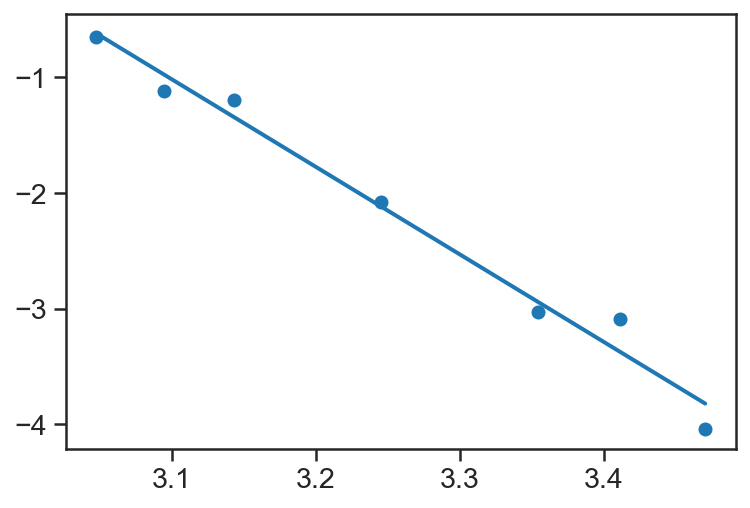

In [13]:
    a, b = best_fit(xval, yval)
    plt.scatter(xval, yval)
    yfit = [a + b * xi for xi in xval]
    plt.plot(xval, yfit)
    plt.show()



  0%|                                                     | 0/1 [00:00<?, ?it/s]

     Unnamed: 0  start   end  charge         BE   sequence temperature  \
627           9   31.0  39.0     3.0  84.691429  LRVTGEVRE      WT-15C   
628           9   31.0  39.0     3.0  84.691429  LRVTGEVRE      WT-15C   
..          ...    ...   ...     ...        ...        ...         ...   
834           9   31.0  39.0     3.0  84.691429  LRVTGEVRE      WT-55C   
835           9   31.0  39.0     3.0  84.691429  LRVTGEVRE      WT-55C   

     timepoint  replicate   percentD valid  percentD_good  percentD_corr  AAs  \
627        0.0          1   0.000000  true       0.000000       0.000000    9   
628        0.0          2   0.000000  true       0.000000       0.000000    9   
..         ...        ...        ...   ...            ...            ...  ...   
834      240.0          1  58.747619  true      58.747619      69.366664    9   
835      240.0          2  56.457143  true      56.457143      66.662169    9   

     #P  NH-total   Daltons       avg        sd  NH_exchange_max  a_

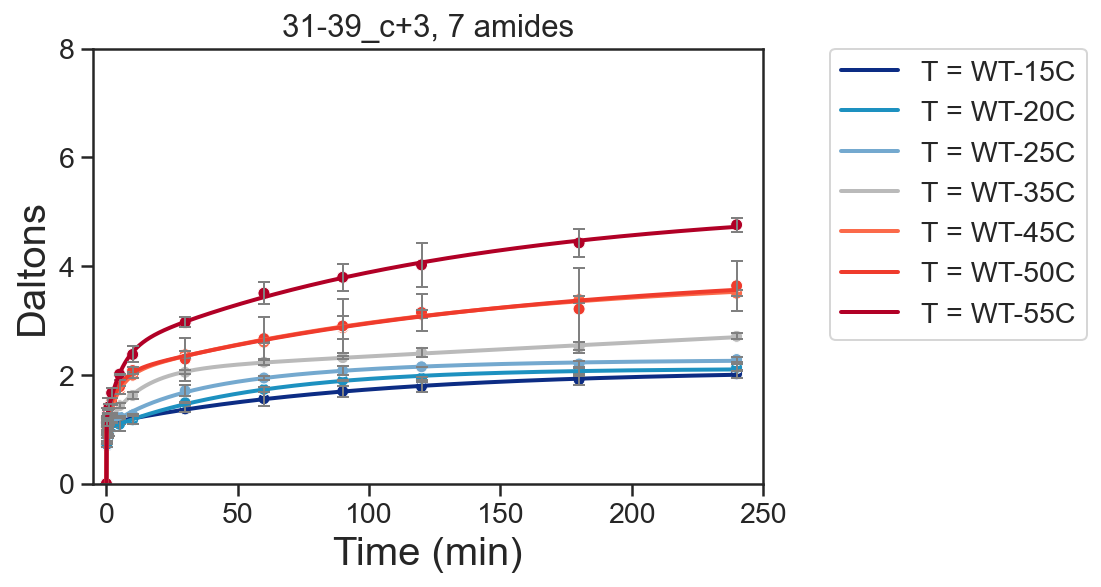


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


In [143]:
'''
plot with x-axis linear
'''        
bound_data=pd.DataFrame(pd.read_csv("parameters_hdx.csv"))
#combining with csv with specified initial values and bounds
WT_bounds = pd.merge(WTmerged, bound_data, how='outer', on=['start','end'])

##I commented this out, but you can utilize this to TRY different selectors
#WT_bounds=WT_bounds.loc[WTmerged["start"]==31]

groups2 = WT_bounds.groupby(by = ['start', 'end', 'charge', 'sequence', 'NH-total'], as_index = False)
num_groups = len(groups2)

for upep, upepDF in tqdm(groups2, total = num_groups):
    upepDF = upepDF.dropna(subset = ['avg'])
    print(upepDF)
    ylim = upepDF['NH-total'].iloc[0]+1

    for tempInfo, tempDF in upepDF.groupby(by = ['start', 'end', 'temperature']):
        start, end, temperature = tempInfo
        Nobs = tempDF['NH_exchange_max'].iloc[0]
        if Nobs == 0:
            Nobs = 0.1
        Ai=tempDF['a_initial'].iloc[0]
        Bi=tempDF['b_initial'].iloc[0]
        Ci=tempDF['c_initial'].iloc[0]
        k1i=tempDF['k1_initial'].iloc[0]
        k2i=tempDF['k2_initial'].iloc[0]
        k3i=tempDF['k3_initial'].iloc[0]
        NHi=tempDF['Ntotal_initial'].iloc[0]
        NHcap=tempDF['Ntotal_cap'].iloc[0]
        a_bound =tempDF['k1_cap'].iloc[0]
        b_bound =tempDF['k2_cap'].iloc[0]
        #new_variable=tempDF['name'].iloc[0]

        
        #pinitial = Ntot*0.25, Ntot*0.25, Ntot*0.25, 20, 0.1, 0.01, Ntot*0.25
       # bbounds = ([0,0,0,0,0.0,0,0],[Ntot*1.0,Ntot*1.0,Ntot*1.0,100,10,1,Ntot*1.2])
        
                #new_variable=tempDF['name'].iloc[0]

        
        
        #pinitial = Ntot*.5, Ntot*.5, Ntot*.5, 20, 0.5, 0.01, Ntot*1
        #bbounds = ([0,0,0,0,0,0,0],[Ntot*1.05,Ntot*1.05,Ntot*1.05,100,2.5,0.05,Ntot*1.2])
        pinitial = Ai, Bi, Ci, k1i, k2i, k3i, NHi
        bbounds = ([0,0,0,a_bound,b_bound,0,Nobs*0.9],[Ntot*1.1,Ntot*1.1,Ntot*1.1,1000,a_bound,b_bound,NHcap])

        plotfit(tempDF, x = 'timepoint', y = 'avg', yerr = 'sd', hue = 'temperature',
                func = Exp3a, colors = temp2color, 
                p0 = pinitial, 
                bounds = bbounds)  

    plt.xlabel('Time (min)', fontsize=20)
    plt.ylabel('Daltons', fontsize=20)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.ylim(0, ylim)
    plt.xlim(-5, 250)
    
#    sns.despine()
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2})
    figname = 'Linear_fit/%s-%s_c+%s.png' % (int(upep[0]), int(upep[1]), int(upep[2]))
    plt.title('%s-%s_c+%s, %s amides' % (int(upep[0]), int(upep[1]), int(upep[2]), ylim-1))
#    print(figname)
    plt.savefig(figname, bbox_inches='tight')
    plt.show();

    
# plt title gives peptide, charge, and number of reporting amides:
# eg 2-23_c+3, 19 amides = peptide 2-23, +3 charge, with 19 amides

In [14]:
#make a new column for the max exchange value (NH_exchange_max) for each unique dataset - this value will be used in the fitting
# this puts NH exchange max into everything, I added the replicate to do it individually per replicate

merged3 = {}
merged3['NH_exchange_max'] = []
merged3['start'] = []
merged3['end'] = []
merged3['charge'] = []
merged3['temperature'] = []
merged3['replicate']=[]
substt = ['charge', 'start', 'end', 'temperature', 'replicate']
for add, adds in mergedc.groupby(by = substt):
    tt = adds['Daltons'].max()
    merged3['NH_exchange_max'].append(tt)
    merged3['replicate'].append(adds['replicate'].iloc[0])
    merged3['start'].append(adds['start'].iloc[0])
    merged3['end'].append(adds['end'].iloc[0])
    merged3['charge'].append(adds['charge'].iloc[0])
    merged3['temperature'].append(adds['temperature'].iloc[0])
merged3 = pd.DataFrame(merged3)


WTmerged = pd.merge(mergedc, merged3, 
               how = 'outer', 
               on = ['charge', 'start', 'end', 'temperature','replicate'])

WTmerged.groupby(by=substt)
WTmerged.to_csv('WTmerged.tsv', sep="\t")
WTmerged

,Unnamed: 0,start,end,charge,BE,sequence,temperature,timepoint,replicate,percentD,valid,percentD_good,percentD_corr,AAs,#P,NH-total,Daltons,avg,sd,NH_exchange_max
0,0,1.0,12.0,3.0,50.2575,GGSMRSRRVDVM,15C,0.000000,1,0.000000,true,0.000000,0.000000,12,0,10,0.000000,0.000000,0.000000,9.705351
1,0,1.0,12.0,3.0,50.2575,GGSMRSRRVDVM,15C,0.166667,1,32.813333,true,32.813333,65.290421,12,0,10,6.529042,6.936941,0.576857,9.705351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,306,224.0,231.0,2.0,80.9070,SIKDLLNP,55C,180.000000,2,82.960000,true,82.960000,102.537481,8,1,5,5.126874,5.010554,0.164501,5.159284
5249,306,224.0,231.0,2.0,80.9070,SIKDLLNP,55C,240.000000,2,82.528889,true,82.528889,102.004634,8,1,5,5.100232,4.922799,0.250928,5.159284


In [16]:
# defining how to put all the fitted data in a table

def fitdata(WTmerged, x, y, hue, func, colors):
    k2_df = []
    k_df = {'variable':[], 'value':[], 'temperature':[], 'std.dev.res':[], 'DOF':[], 'Nobs':[]}
    for category, subset in WTmerged.groupby(by = ['temperature']):
        X = subset[x].values
        Y = subset[y].values
        try: 
            Nobs = subset['NH_exchange_max'].iloc[0]
            Ntot = subset['NH-total'].iloc[0]
            if Nobs == 0:
                Nobs = 0.1
            Ai=subset['a_initial'].iloc[0]
            Bi=subset['b_initial'].iloc[0]
            Ci=subset['c_initial'].iloc[0]
            k1i=subset['k1_initial'].iloc[0]
            k2i=subset['k2_initial'].iloc[0]
            k3i=subset['k3_initial'].iloc[0]
            NHi=subset['Ntotal_initial'].iloc[0]
            NHcap=subset['Ntotal_cap'].iloc[0]
            a_bound=subset['k1_cap'].iloc[0]
            b_bound=subset['k2_cap'].iloc[0]
            NHlow=subset['Ntotal_low'].iloc[0]
            #NHlow=tempDF['Ntotal_low'].iloc[0]
            #new_variable=tempDF['name'].iloc[0]


            #pinitial = Nobs*0.25, Nobs*0.25, Nobs*0.25, 50, 0.5, 0.0025, Nobs
            #bbounds = ([0,0,0,10,0.05,0,Nobs*0.9],[Nobs*1.1,Nobs*1.1,Nobs*1.1,1000,10,0.05,Nobs*1.1])
            #pinitial = Nobs*0.33, Nobs*0.33, Nobs*0.33, 50, 0.1, 0.001, Nobs
            #bbounds = ([0,0,0,1,0.01,0,Nobs*0.9],[Ntot*1.1,Ntot*1.1,Ntot*1.1,1000,1,0.01,Ntot*1.1])
            pinitial = Ai, Bi, Ci, k1i, k2i, k3i, NHi
            bbounds = ([0,0,0,a_bound,b_bound,0,NHlow],[Ntot*1.1,Ntot*1.1,Ntot*1.1,100,a_bound,b_bound,NHcap])
            
            
            #pinitial = Ai, Bi, Ci, k1i, k2i, k3i, NHi
            #bbounds = ([0,0,0,a_bound,b_bound,0,NHlow],[Ntot*1.1,Ntot*1.1,Ntot*1.1,1000,a_bound,b_bound,NHcap])
            print (pinitial)
            print(bbounds)

            
            popt, pcov = curve_fit(func, X, Y, p0 = pinitial, bounds = bbounds)
            SDR = ((sum((Y - func(X, *popt))**2))/(len(Y)-len(pinitial)-2))**0.5

            for variable, value in zip(['a', 'b', 'c', 'd', 'e', 'f', 'g'], popt):
                k_df['variable'].append(variable)
                k_df['value'].append(value)
                k_df['temperature'].append(category)
                k_df['std.dev.res'].append(SDR)
                k_df['DOF'].append(len(Y)-len(pinitial)-1)
                k_df['Nobs'].append(Nobs)

        except RuntimeError:
            for variable, value in zip(['a', 'b', 'c', 'd', 'e', 'f', 'g'], [np.nan]):
                k_df['variable'].append(variable)
                k_df['value'].append(value)
                k_df['temperature'].append(category)
                k_df['std.dev.res'].append(value)
                k_df['DOF'].append(len(Y)-len(pinitial)-1)
                k_df['Nobs'].append(Nobs)
        k2_df.append(pd.DataFrame(k_df))
    return pd.DataFrame(k_df)     

In [17]:
# this fits the valeus to the 7 terms in the equation for each replicate
WTresults = []
bound_data=pd.DataFrame(pd.read_csv("parameters_hdx_3b1.csv"))
#combining with csv with specified initial values and bounds
WT_bounds = pd.merge(WTmerged, bound_data, how='outer', on=['start','end','charge','temperature'])
groups = WT_bounds.groupby(by = ['sequence', 'charge', 'start', 'end','replicate'], as_index = False)
num_groups = len(groups)
for pep_u, b in tqdm(groups, total = num_groups):
    print(b)

    #pinitial = Ntot*0.25, Ntot*0.25, Ntot*0.25, 20, 0.1, 0.01, Ntot*0.25
    #bbounds = ([0,0,0,0,0.0,0,0],[Ntot*1.0,Ntot*1.0,Ntot*1.0,100,10,1,Ntot*1.1])
    
    #pinitial = Nobs*0.25, Nobs*0.25, Nobs*0.25, 50, 0.5, 0.0025, Nobs
    #bbounds = ([0,0,0,10,0.05,0,Nobs*0.25],[Nobs*1.1,Nobs*1.1,Nobs*1.1,1000,10,0.05,Nobs*1.1])
    upepDF = b.dropna(subset = ['Daltons'])  
    results = fitdata(upepDF, x = 'timepoint', y = 'Daltons', hue = 'temperature',
                          func = Exp3a, colors = temp2color)
    results['sequence'] = [pep_u[0] for i in results['variable']]
    results['charge'] = [pep_u[1] for i in results['variable']]
    results['start'] = [pep_u[2] for i in results['variable']]
    results['end'] = [pep_u[3] for i in results['variable']]
    results['replicate'] = [pep_u[4] for i in results['variable']]
    #results['temperature'] = [pep_u[5] for i in results['variable']]
    WTresults.append(results) 

WTresults = pd.concat(WTresults)
WTresults.to_csv('WT_results.tsv', sep="\t")
WTresults

  2%|▏         | 1/50 [00:00<00:08,  6.10it/s]

      Unnamed: 0  start    end  charge         BE           sequence  \
1890          99   97.0  113.0     2.0  44.333214  AIIVHGFPGADSVRACL   
1891          99   97.0  113.0     2.0  44.333214  AIIVHGFPGADSVRACL   
...          ...    ...    ...     ...        ...                ...   
2083          99   97.0  113.0     2.0  44.333214  AIIVHGFPGADSVRACL   
2084          99   97.0  113.0     2.0  44.333214  AIIVHGFPGADSVRACL   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
1890         15C    0.000000          1   0.000000  true       0.000000   
1891         15C    0.166667          1   7.934921  true       7.934921   
...          ...         ...        ...        ...   ...            ...   
2083         55C  180.000000          1  24.342857  true      24.342857   
2084         55C  240.000000          1  21.790476  true      21.790476   

      percentD_corr  AAs  #P  NH-total   Daltons       avg        sd  \
1890       0.000000   17   1        14  0.00

  4%|▍         | 2/50 [00:00<00:06,  7.09it/s]

(1.0, 2.0, 1.0, 20, 0.5, 0.0025, 7.0)
([0, 0, 0, 2.0, 0.01, 0, 5.0], [15.400000000000002, 15.400000000000002, 15.400000000000002, 100, 2.0, 0.01, 14])
(1.0, 2.0, 2.0, 20, 0.5, 0.0025, 7.0)
([0, 0, 0, 2.0, 0.01, 0, 5.0], [15.400000000000002, 15.400000000000002, 15.400000000000002, 100, 2.0, 0.01, 14])
(2.0, 2.0, 3.0, 20, 0.5, 0.0025, 7.0)
([0, 0, 0, 5.0, 0.01, 0, 5.0], [15.400000000000002, 15.400000000000002, 15.400000000000002, 100, 5.0, 0.01, 14])
(2.0, 2.0, 2.0, 20, 0.5, 0.0025, 7.0)
([0, 0, 0, 5.0, 0.01, 0, 5.0], [15.400000000000002, 15.400000000000002, 15.400000000000002, 100, 5.0, 0.01, 14])
      Unnamed: 0  start    end  charge         BE           sequence  \
2100         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   
2101         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   
...          ...    ...    ...     ...        ...                ...   
2293         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   
2294         117   97.0  113.0     3

  8%|▊         | 4/50 [00:00<00:05,  7.88it/s]

      Unnamed: 0  start    end  charge         BE           sequence  \
2115         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   
2116         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   
...          ...    ...    ...     ...        ...                ...   
2308         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   
2309         117   97.0  113.0     3.0  44.333214  AIIVHGFPGADSVRACL   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
2115         15C    0.000000          2   0.000000  true       0.000000   
2116         15C    0.166667          2   5.130952  true       5.130952   
...          ...         ...        ...        ...   ...            ...   
2308         55C  180.000000          2  20.840476  true      20.840476   
2309         55C  240.000000          2  22.090476  true      22.090476   

      percentD_corr  AAs  #P  NH-total   Daltons       avg        sd  \
2115       0.000000   17   1        14  0.00

 10%|█         | 5/50 [00:00<00:05,  8.35it/s]

(2.5, 3.0, 3.0, 20, 0.5, 0.0025, 6.0)
([0, 0, 0, 5.0, 0.01, 0, 5.0], [16.5, 16.5, 16.5, 100, 5.0, 0.01, 15])
      Unnamed: 0  start    end  charge         BE            sequence  \
2325         135   97.0  114.0     2.0  45.810083  AIIVHGFPGADSVRACLN   
2326         135   97.0  114.0     2.0  45.810083  AIIVHGFPGADSVRACLN   
...          ...    ...    ...     ...        ...                 ...   
2518         135   97.0  114.0     2.0  45.810083  AIIVHGFPGADSVRACLN   
2519         135   97.0  114.0     2.0  45.810083  AIIVHGFPGADSVRACLN   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
2325         15C    0.000000          2   0.000000  true       0.000000   
2326         15C    0.166667          2   5.774815  true       5.774815   
...          ...         ...        ...        ...   ...            ...   
2518         55C  180.000000          2  25.131852  true      25.131852   
2519         55C  240.000000          2  26.524444  true      26.524444   

 

 18%|█▊        | 9/50 [00:01<00:04,  9.86it/s]

      Unnamed: 0  start    end  charge         BE            sequence  \
2535         153   97.0  114.0     3.0  45.810083  AIIVHGFPGADSVRACLN   
2536         153   97.0  114.0     3.0  45.810083  AIIVHGFPGADSVRACLN   
...          ...    ...    ...     ...        ...                 ...   
2728         153   97.0  114.0     3.0  45.810083  AIIVHGFPGADSVRACLN   
2729         153   97.0  114.0     3.0  45.810083  AIIVHGFPGADSVRACLN   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
2535         15C    0.000000          2   0.000000  true       0.000000   
2536         15C    0.166667          2   8.097778  true       8.097778   
...          ...         ...        ...        ...   ...            ...   
2728         55C  180.000000          2  25.071111  true      25.071111   
2729         55C  240.000000          2  26.313333  true      26.313333   

      percentD_corr  AAs  #P  NH-total   Daltons       avg        sd  \
2535       0.000000   18   1        15

 22%|██▏       | 11/50 [00:01<00:03, 10.37it/s]

     Unnamed: 0  start   end  charge         BE     sequence temperature  \
435          18   21.0  31.0     1.0  48.970417  AMDLMNRDDAL         15C   
436          18   21.0  31.0     1.0  48.970417  AMDLMNRDDAL         15C   
..          ...    ...   ...     ...        ...          ...         ...   
628          18   21.0  31.0     1.0  48.970417  AMDLMNRDDAL         55C   
629          18   21.0  31.0     1.0  48.970417  AMDLMNRDDAL         55C   

      timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
435    0.000000          2   0.000000  true       0.000000       0.000000   
436    0.166667          2   7.246914  true       7.246914      14.798554   
..          ...        ...        ...   ...            ...            ...   
628  180.000000          2  41.258025  true      41.258025      84.250916   
629  240.000000          2  41.720988  true      41.720988      85.196309   

     AAs  #P  NH-total   Daltons       avg        sd  NH_exchange_max  \
435   1

(2.0, 3.0, 1.0, 20, 0.25, 0.01, 8.0)
([0, 0, 0, 5.0, 0.05, 0, 8.0], [9.9, 9.9, 9.9, 100, 5.0, 0.05, 9])
(3.0, 3.0, 1.0, 20, 0.25, 0.01, 8.0)
([0, 0, 0, 5.0, 0.05, 0, 8.0], [9.9, 9.9, 9.9, 100, 5.0, 0.05, 9])
(3.0, 3.0, 1.0, 20, 0.25, 0.01, 7.0)
([0, 0, 0, 5.0, 0.05, 0, 7.0], [9.9, 9.9, 9.9, 100, 5.0, 0.05, 9])
(3.0, 3.0, 1.0, 20, 0.25, 0.01, 8.0)
([0, 0, 0, 5.0, 0.1, 0, 8.0], [9.9, 9.9, 9.9, 100, 5.0, 0.1, 9])
(4.0, 3.0, 1.0, 20, 0.25, 0.01, 8.0)
([0, 0, 0, 5.0, 0.1, 0, 8.0], [9.9, 9.9, 9.9, 100, 5.0, 0.1, 9])
(4.0, 3.0, 1.0, 20, 0.25, 0.01, 6.5)
([0, 0, 0, 5.0, 0.1, 0, 6.0], [9.9, 9.9, 9.9, 100, 5.0, 0.1, 9])
     Unnamed: 0  start   end  charge         BE  sequence temperature  \
210           9   13.0  20.0     2.0  45.431667  DVMNRLIL         15C   
211           9   13.0  20.0     2.0  45.431667  DVMNRLIL         15C   
..          ...    ...   ...     ...        ...       ...         ...   
403           9   13.0  20.0     2.0  45.431667  DVMNRLIL         55C   
404           9  

 26%|██▌       | 13/50 [00:01<00:03,  9.96it/s]

     Unnamed: 0  start   end  charge         BE  sequence temperature  \
225           9   13.0  20.0     2.0  45.431667  DVMNRLIL         15C   
226           9   13.0  20.0     2.0  45.431667  DVMNRLIL         15C   
..          ...    ...   ...     ...        ...       ...         ...   
418           9   13.0  20.0     2.0  45.431667  DVMNRLIL         55C   
419           9   13.0  20.0     2.0  45.431667  DVMNRLIL         55C   

      timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
225    0.000000          2   0.000000  true       0.000000       0.000000   
226    0.166667          2   5.518519  true       5.518519      12.146855   
..          ...        ...        ...   ...            ...            ...   
418  180.000000          2  40.625926  true      40.625926      89.422046   
419  240.000000          2  41.488889  true      41.488889      91.321521   

     AAs  #P  NH-total   Daltons       avg        sd  NH_exchange_max  \
225    8   0         6  0

 30%|███       | 15/50 [00:01<00:03,  9.07it/s]

(2.0, 2.0, 2.0, 20, 0.05, 0.001, 5.0)
([0, 0, 0, 1.5, 0.05, 0, 3.0], [16.5, 16.5, 16.5, 100, 1.5, 0.05, 15])
(2.0, 2.0, 2.0, 20, 0.05, 0.001, 5.0)
([0, 0, 0, 1.5, 0.05, 0, 3.0], [16.5, 16.5, 16.5, 100, 1.5, 0.05, 15])
(2.0, 2.0, 2.0, 20, 0.05, 0.001, 5.0)
([0, 0, 0, 1.5, 0.05, 0, 3.0], [16.5, 16.5, 16.5, 100, 1.5, 0.05, 15])
      Unnamed: 0  start   end  charge       BE            sequence  \
1695          90   74.0  91.0     3.0  56.5405  FKVADIPETNEKICRATF   
1696          90   74.0  91.0     3.0  56.5405  FKVADIPETNEKICRATF   
...          ...    ...   ...     ...      ...                 ...   
1888          90   74.0  91.0     3.0  56.5405  FKVADIPETNEKICRATF   
1889          90   74.0  91.0     3.0  56.5405  FKVADIPETNEKICRATF   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
1695         15C    0.000000          2   0.000000  true       0.000000   
1696         15C    0.166667          2   4.308889  true       4.308889   
...          ...         ..

 34%|███▍      | 17/50 [00:01<00:03,  8.55it/s]

     Unnamed: 0  start   end  charge       BE      sequence temperature  \
0             0    1.0  12.0     3.0  50.2575  GGSMRSRRVDVM         15C   
1             0    1.0  12.0     3.0  50.2575  GGSMRSRRVDVM         15C   
..          ...    ...   ...     ...      ...           ...         ...   
193           0    1.0  12.0     3.0  50.2575  GGSMRSRRVDVM         55C   
194           0    1.0  12.0     3.0  50.2575  GGSMRSRRVDVM         55C   

      timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
0      0.000000          1   0.000000  true       0.000000       0.000000   
1      0.166667          1  32.813333  true      32.813333      65.290421   
..          ...        ...        ...   ...            ...            ...   
193  180.000000          1  46.486667  true      46.486667      92.496974   
194  240.000000          1  44.216667  true      44.216667      87.980235   

     AAs  #P  NH-total   Daltons       avg        sd  NH_exchange_max  \
0     12   0 

 38%|███▊      | 19/50 [00:02<00:04,  7.08it/s]

(0.2, 0.5, 0.5, 20, 0.01, 0.0025, 1.0)
([0, 0, 0, 0.2, 0.005, 0, 0.1], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.2, 0.005, 6])
(0.2, 0.5, 0.5, 20, 0.01, 0.0025, 1.0)
([0, 0, 0, 0.5, 0.005, 0, 0.1], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.5, 0.005, 6])
(0.2, 0.5, 0.5, 20, 0.01, 0.0025, 1.0)
([0, 0, 0, 0.5, 0.005, 0, 0.1], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.5, 0.005, 6])
      Unnamed: 0  start    end  charge         BE  sequence temperature  \
3375         198  145.0  152.0     2.0  46.219167  IARMGVDL         15C   
3376         198  145.0  152.0     2.0  46.219167  IARMGVDL         15C   
...          ...    ...    ...     ...        ...       ...         ...   
3568         198  145.0  152.0     2.0  46.219167  IARMGVDL         55C   
3569         198  145.0  152.0     2.0  46.219167  IARMGVDL         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
3375    0.00

 40%|████      | 20/50 [00:02<00:04,  7.00it/s]

(0.2, 0.5, 0.5, 20, 0.01, 0.0025, 1.0)
([0, 0, 0, 0.5, 0.005, 0, 0.1], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.5, 0.005, 6])
(0.2, 0.5, 0.5, 20, 0.01, 0.0025, 1.0)
([0, 0, 0, 0.5, 0.005, 0, 0.1], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.5, 0.005, 6])
      Unnamed: 0  start   end  charge         BE sequence temperature  \
1260          72   58.0  62.0     1.0  51.183333    IIAEF         15C   
1261          72   58.0  62.0     1.0  51.183333    IIAEF         15C   
...          ...    ...   ...     ...        ...      ...         ...   
1453          72   58.0  62.0     1.0  51.183333    IIAEF         55C   
1454          72   58.0  62.0     1.0  51.183333    IIAEF         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
1260    0.000000          1   0.000000  true       0.000000       0.000000   
1261    0.166667          1   0.192593  true       0.192593       0.376280   
...          ...     

 42%|████▏     | 21/50 [00:02<00:06,  4.58it/s]

(0.0, 1.0, 2.0, 50, 1.0, 0.0025, 2.5)
([0, 0, 0, 5.0, 0.1, 0, 2.0], [3.3000000000000003, 3.3000000000000003, 3.3000000000000003, 100, 5.0, 0.1, 3])
(0.0, 2.0, 1.0, 50, 1.0, 0.0025, 2.5)
([0, 0, 0, 5.0, 0.1, 0, 2.0], [3.3000000000000003, 3.3000000000000003, 3.3000000000000003, 100, 5.0, 0.1, 3])
(0.0, 2.0, 1.0, 50, 1.0, 0.0025, 2.5)
([0, 0, 0, 5.0, 0.1, 0, 2.0], [3.3000000000000003, 3.3000000000000003, 3.3000000000000003, 100, 5.0, 0.1, 3])
      Unnamed: 0  start   end  charge         BE sequence temperature  \
1275          72   58.0  62.0     1.0  51.183333    IIAEF         15C   
1276          72   58.0  62.0     1.0  51.183333    IIAEF         15C   
...          ...    ...   ...     ...        ...      ...         ...   
1468          72   58.0  62.0     1.0  51.183333    IIAEF         55C   
1469          72   58.0  62.0     1.0  51.183333    IIAEF         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
1275    0.000000          2   0.000000 

 46%|████▌     | 23/50 [00:03<00:05,  5.34it/s]


(0.0, 2.0, 1.0, 50, 1.0, 0.0025, 2.5)
([0, 0, 0, 5.0, 0.1, 0, 2.0], [3.3000000000000003, 3.3000000000000003, 3.3000000000000003, 100, 5.0, 0.1, 3])
      Unnamed: 0  start    end  charge         BE  sequence temperature  \
4410         261  202.0  209.0     2.0  67.926667  IIVGRSIY         15C   
4411         261  202.0  209.0     2.0  67.926667  IIVGRSIY         15C   
...          ...    ...    ...     ...        ...       ...         ...   
4603         261  202.0  209.0     2.0  67.926667  IIVGRSIY         55C   
4604         261  202.0  209.0     2.0  67.926667  IIVGRSIY         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
4410    0.000000          1   0.000000  true       0.000000       0.000000   
4411    0.166667          1  22.318519  true      22.318519      32.856785   
...          ...        ...        ...   ...            ...            ...   
4603  180.000000          1  63.233333  true      63.233333      93.090588   
4604  240.

 48%|████▊     | 24/50 [00:03<00:04,  5.69it/s]

(1.0, 2.0, 0.4, 20, 0.05, 0.0025, 2.5)
([0, 0, 0, 0.05, 0.005, 0, 2.0], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.05, 0.005, 6])
(1.0, 2.0, 0.5, 20, 0.05, 0.0025, 2.5)
([0, 0, 0, 0.05, 0.005, 0, 2.0], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.05, 0.005, 6])
(1.0, 2.0, 1.0, 20, 0.05, 0.0025, 2.5)
([0, 0, 0, 0.1, 0.005, 0, 2.0], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.1, 0.005, 6])
(1.0, 2.0, 2.0, 20, 0.05, 0.0025, 2.5)
([0, 0, 0, 0.5, 0.005, 0, 2.0], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 0.5, 0.005, 6])
(1.0, 2.0, 2.0, 20, 0.05, 0.0025, 2.5)
([0, 0, 0, 1.0, 0.005, 0, 2.0], [6.6000000000000005, 6.6000000000000005, 6.6000000000000005, 100, 1.0, 0.005, 6])
      Unnamed: 0  start    end  charge         BE          sequence  \
4620         270  208.0  223.0     1.0  77.074615  IYLADNPAAAAAGIIE   
4621         270  208.0  223.0     1.0  77.074615  IYLADNPAAAAAGIIE   
...          ...  

 52%|█████▏    | 26/50 [00:03<00:03,  6.21it/s]

(2.0, 1.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 1.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 1.0, 0.005, 14])
(2.0, 2.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.005, 14])
(2.0, 4.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
(2.0, 5.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
(2.0, 5.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
      Unnamed: 0  start    end  charge         BE          sequence  \
4635         270  208.0  223.0     1.0  77.074615  IYLADNPAAAAAGIIE   
4636         270  208.0  223.0     1.0  77.074615  IYLADNPAAAAAGIIE   
...          ...    ...    ...     ...        ...               ...   
4828         270  208.0  223.0     1.0  77.074615  IYLADNPAAAAAGIIE   
4829         270  208.0  223.0     1.0  77.074615  IYLADNPAAAAAGIIE   

     temperature   timep

 54%|█████▍    | 27/50 [00:03<00:03,  5.78it/s]

(2.0, 1.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 1.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 1.0, 0.005, 14])
(2.0, 1.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 1.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 1.0, 0.005, 14])
(2.0, 2.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.005, 14])
(2.0, 4.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
(2.0, 5.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
(2.0, 5.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
      Unnamed: 0  start    end  charge         BE          sequence  \
4845         288  208.0  223.0     2.0  77.074615  IYLADNPAAAAAGIIE   
4846         288  208.0  223.0     2.0  77.074615  IYLADNPAAAAAGIIE   
...          ...    ...    ...     ...        ...               ...   
5038         288  208.0  223.0     2.0  77.074615  IYLAD

 56%|█████▌    | 28/50 [00:04<00:04,  5.37it/s]

(2.0, 1.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 1.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 1.0, 0.005, 14])
(2.0, 2.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.005, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.005, 14])
(2.0, 4.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
(2.0, 5.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
(2.0, 5.0, 1.0, 20, 0.5, 0.0025, 8.0)
([0, 0, 0, 2.0, 0.01, 0, 3.0], [14.3, 14.3, 14.3, 100, 2.0, 0.01, 14])
      Unnamed: 0  start    end  charge    BE      sequence temperature  \
2940         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         15C   
2941         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         15C   
...          ...    ...    ...     ...   ...           ...         ...   
3133         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         55C   
3134         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         55C   

      

 60%|██████    | 30/50 [00:04<00:02,  7.11it/s]

(2.0, 1.0, 1.0, 20, 0.1, 0.001, 8.0)
([0, 0, 0, 2.5, 0.01, 0, 6.0], [9.9, 9.9, 9.9, 100, 2.5, 0.01, 9])
(2.0, 1.0, 1.0, 20, 0.1, 0.001, 8.0)
([0, 0, 0, 2.5, 0.02, 0, 6.0], [9.9, 9.9, 9.9, 100, 2.5, 0.02, 9])
(2.0, 1.0, 1.0, 20, 0.1, 0.001, 8.0)
([0, 0, 0, 10.0, 0.05, 0, 6.0], [9.9, 9.9, 9.9, 100, 10.0, 0.05, 9])
      Unnamed: 0  start    end  charge    BE      sequence temperature  \
2955         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         15C   
2956         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         15C   
...          ...    ...    ...     ...   ...           ...         ...   
3148         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         55C   
3149         180  125.0  136.0     2.0  56.0  LATEMSHPGAEM         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
2955    0.000000          2   0.000000  true       0.000000       0.000000   
2956    0.166667          2  11.170370  true      11.170370      19.947090   
...    

 62%|██████▏   | 31/50 [00:04<00:02,  7.18it/s]

(4.0, 2.5, 0.5, 10, 0.1, 0.0025, 7.0)
([0, 0, 0, 2.0, 0.025, 0, 5.0], [16.5, 16.5, 16.5, 100, 2.0, 0.025, 15])
(4.0, 2.5, 0.5, 20, 0.1, 0.0025, 7.0)
([0, 0, 0, 2.0, 0.05, 0, 5.0], [16.5, 16.5, 16.5, 100, 2.0, 0.05, 15])
      Unnamed: 0  start    end  charge         BE             sequence  \
3585         207  152.0  170.0     4.0  61.057333  LGVKNYVGPSTRPERLSRL   
3586         207  152.0  170.0     4.0  61.057333  LGVKNYVGPSTRPERLSRL   
...          ...    ...    ...     ...        ...                  ...   
3778         207  152.0  170.0     4.0  61.057333  LGVKNYVGPSTRPERLSRL   
3779         207  152.0  170.0     4.0  61.057333  LGVKNYVGPSTRPERLSRL   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
3585         15C    0.000000          2   0.000000  true       0.000000   
3586         15C    0.166667          2  10.640000  true      10.640000   
...          ...         ...        ...        ...   ...            ...   
3778         55C  180.000000       

 66%|██████▌   | 33/50 [00:04<00:02,  8.45it/s]

(10.0, 5.0, 1.0, 10, 0.1, 0.005, 13.0)
([0, 0, 0, 1.5, 0.07, 0, 11.0], [19.8, 19.8, 19.8, 100, 1.5, 0.07, 18])
      Unnamed: 0  start    end  charge         BE                sequence  \
4215         252  180.0  201.0     2.0  62.635833  LISPGVGAQGGDPGETLRFADA   
4216         252  180.0  201.0     2.0  62.635833  LISPGVGAQGGDPGETLRFADA   
...          ...    ...    ...     ...        ...                     ...   
4408         252  180.0  201.0     2.0  62.635833  LISPGVGAQGGDPGETLRFADA   
4409         252  180.0  201.0     2.0  62.635833  LISPGVGAQGGDPGETLRFADA   

     temperature   timepoint  replicate   percentD valid  percentD_good  \
4215         15C    0.000000          2   0.000000  true       0.000000   
4216         15C    0.166667          2  13.604938  true      13.604938   
...          ...         ...        ...        ...   ...            ...   
4408         55C  180.000000          2  59.820988  true      59.820988   
4409         55C  240.000000          2  60.390123 

 72%|███████▏  | 36/50 [00:04<00:01,  8.65it/s]

      Unnamed: 0  start   end  charge         BE   sequence temperature  \
855           54   31.0  39.0     3.0  55.489286  LRVTGEVRE         15C   
856           54   31.0  39.0     3.0  55.489286  LRVTGEVRE         15C   
...          ...    ...   ...     ...        ...        ...         ...   
1048          54   31.0  39.0     3.0  55.489286  LRVTGEVRE         55C   
1049          54   31.0  39.0     3.0  55.489286  LRVTGEVRE         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
855     0.000000          2   0.000000  true       0.000000       0.000000   
856     0.166667          2   4.323810  true       4.323810       7.792152   
...          ...        ...        ...   ...            ...            ...   
1048  180.000000          2  36.861905  true      36.861905      66.430671   
1049  240.000000          2  35.938095  true      35.938095      64.765828   

      AAs  #P  NH-total   Daltons       avg        sd  NH_exchange_max  \
855   

 76%|███████▌  | 38/50 [00:05<00:01,  9.34it/s]

(0.5, 3.0, 0.5, 10, 0.05, 0.0025, 6.0)
([0, 0, 0, 2.0, 0.01, 0, 4.0], [7.700000000000001, 7.700000000000001, 7.700000000000001, 100, 2.0, 0.01, 7])
      Unnamed: 0  start    end  charge         BE   sequence temperature  \
3165         189  136.0  144.0     1.0  62.001071  MFIQGAADE         15C   
3166         189  136.0  144.0     1.0  62.001071  MFIQGAADE         15C   
...          ...    ...    ...     ...        ...        ...         ...   
3358         189  136.0  144.0     1.0  62.001071  MFIQGAADE         55C   
3359         189  136.0  144.0     1.0  62.001071  MFIQGAADE         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
3165    0.000000          2   0.000000  true       0.000000       0.000000   
3166    0.166667          2   9.957143  true       9.957143      16.059630   
...          ...        ...        ...   ...            ...            ...   
3358  180.000000          2  64.603175  true      64.603175     104.196868   
3359 

 80%|████████  | 40/50 [00:05<00:01,  8.50it/s]

(1.0, 2.0, 3.0, 20, 0.5, 0.0025, 3.0)
([0, 0, 0, 2.5, 0.01, 0, 2.0], [9.9, 9.9, 9.9, 100, 2.5, 0.01, 9])
(1.0, 2.0, 3.0, 20, 0.5, 0.0025, 3.0)
([0, 0, 0, 2.5, 0.01, 0, 2.0], [9.9, 9.9, 9.9, 100, 2.5, 0.01, 9])
      Unnamed: 0  start    end  charge         BE     sequence temperature  \
2745         171  114.0  124.0     2.0  59.026667  NVAEEMGREVF         15C   
2746         171  114.0  124.0     2.0  59.026667  NVAEEMGREVF         15C   
...          ...    ...    ...     ...        ...          ...         ...   
2938         171  114.0  124.0     2.0  59.026667  NVAEEMGREVF         55C   
2939         171  114.0  124.0     2.0  59.026667  NVAEEMGREVF         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
2745    0.000000          2   0.000000  true       0.000000       0.000000   
2746    0.166667          2   3.056790  true       3.056790       5.178660   
...          ...        ...        ...   ...            ...            ...   
2938  180

 82%|████████▏ | 41/50 [00:05<00:01,  8.42it/s]

(2.0, 1.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 1.0, 0.01, 0, 3.0], [8.8, 8.8, 8.8, 100, 1.0, 0.01, 8])
(3.0, 2.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 1.0, 0.01, 0, 3.0], [8.8, 8.8, 8.8, 100, 1.0, 0.01, 8])
(3.0, 2.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.01, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.01, 8])
(3.0, 2.0, 1.0, 20, 0.1, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.025, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.025, 8])
(3.0, 2.0, 1.0, 20, 0.1, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.025, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.025, 8])
      Unnamed: 0  start    end  charge         BE    sequence temperature  \
3795         216  171.0  180.0     1.0  37.791094  REIIGQDSFL         15C   
3796         216  171.0  180.0     1.0  37.791094  REIIGQDSFL         15C   
...          ...    ...    ...     ...        ...         ...         ...   
3988         216  171.0  180.0     1.0  37.791094  REIIGQDSFL         55C   
3989         216  171.0  180.0     1.0  37.791094  REIIGQDSFL         55C   

     

 86%|████████▌ | 43/50 [00:05<00:00,  8.63it/s]

(2.0, 1.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 0.1, 0.005, 0, 3.0], [8.8, 8.8, 8.8, 100, 0.1, 0.005, 8])
(2.0, 1.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 1.0, 0.01, 0, 3.0], [8.8, 8.8, 8.8, 100, 1.0, 0.01, 8])
(3.0, 2.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 1.0, 0.01, 0, 3.0], [8.8, 8.8, 8.8, 100, 1.0, 0.01, 8])
(3.0, 2.0, 1.0, 20, 0.05, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.01, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.01, 8])
(3.0, 2.0, 1.0, 20, 0.1, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.025, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.025, 8])
(3.0, 2.0, 1.0, 20, 0.1, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.025, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.025, 8])
      Unnamed: 0  start    end  charge         BE    sequence temperature  \
4005         234  171.0  180.0     2.0  37.791094  REIIGQDSFL         15C   
4006         234  171.0  180.0     2.0  37.791094  REIIGQDSFL         15C   
...          ...    ...    ...     ...        ...         ...         ...   
4198         234  171.0  180.0     2.0  37.791094  R

 90%|█████████ | 45/50 [00:05<00:00,  8.49it/s]

(3.0, 2.0, 1.0, 20, 0.1, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.025, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.025, 8])
(3.0, 2.0, 1.0, 20, 0.1, 0.0025, 5.0)
([0, 0, 0, 2.5, 0.025, 0, 3.0], [8.8, 8.8, 8.8, 100, 2.5, 0.025, 8])
      Unnamed: 0  start   end  charge       BE      sequence temperature  \
1470          81   63.0  74.0     3.0  47.4585  RKRFGCRIIADF         15C   
1471          81   63.0  74.0     3.0  47.4585  RKRFGCRIIADF         15C   
...          ...    ...   ...     ...      ...           ...         ...   
1663          81   63.0  74.0     3.0  47.4585  RKRFGCRIIADF         55C   
1664          81   63.0  74.0     3.0  47.4585  RKRFGCRIIADF         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
1470    0.000000          1   0.000000  true       0.000000       0.000000   
1471    0.166667          1   2.760000  true       2.760000       5.815607   
...          ...        ...        ...   ...            ...            ...   
1663  180.000000 

 92%|█████████▏| 46/50 [00:06<00:00,  7.94it/s]

(0.5, 3.0, 0.5, 5, 0.05, 0.001, 3.0)
([0, 0, 0, 0.1, 0.005, 0, 2.0], [11.0, 11.0, 11.0, 100, 0.1, 0.005, 10])
(0.5, 3.0, 1.0, 5, 0.05, 0.001, 3.0)
([0, 0, 0, 0.1, 0.005, 0, 2.0], [11.0, 11.0, 11.0, 100, 0.1, 0.005, 10])
(1.0, 4.0, 1.0, 5, 0.5, 0.001, 3.0)
([0, 0, 0, 0.5, 0.0075, 0, 2.0], [11.0, 11.0, 11.0, 100, 0.5, 0.0075, 10])
(1.0, 4.0, 2.0, 5, 0.5, 0.001, 3.0)
([0, 0, 0, 0.5, 0.01, 0, 2.0], [11.0, 11.0, 11.0, 100, 0.5, 0.01, 10])
(1.5, 4.0, 2.0, 5, 0.5, 0.001, 3.0)
([0, 0, 0, 1.0, 0.025, 0, 2.0], [11.0, 11.0, 11.0, 100, 1.0, 0.025, 10])
(1.5, 4.0, 2.0, 5, 0.5, 0.001, 3.0)
([0, 0, 0, 1.0, 0.025, 0, 2.0], [11.0, 11.0, 11.0, 100, 1.0, 0.025, 10])
      Unnamed: 0  start    end  charge      BE  sequence temperature  \
5040         306  224.0  231.0     2.0  80.907  SIKDLLNP         15C   
5041         306  224.0  231.0     2.0  80.907  SIKDLLNP         15C   
...          ...    ...    ...     ...     ...       ...         ...   
5233         306  224.0  231.0     2.0  80.907  SIKDLLNP

 98%|█████████▊| 49/50 [00:07<00:00,  3.99it/s]

      Unnamed: 0  start   end  charge      BE       sequence temperature  \
1050          63   40.0  52.0     2.0  55.137  YIDTVKIGYPLVL         15C   
1051          63   40.0  52.0     2.0  55.137  YIDTVKIGYPLVL         15C   
...          ...    ...   ...     ...     ...            ...         ...   
1243          63   40.0  52.0     2.0  55.137  YIDTVKIGYPLVL         55C   
1244          63   40.0  52.0     2.0  55.137  YIDTVKIGYPLVL         55C   

       timepoint  replicate   percentD valid  percentD_good  percentD_corr  \
1050    0.000000          1   0.000000  true       0.000000       0.000000   
1051    0.166667          1   2.615556  true       2.615556       4.743739   
...          ...        ...        ...   ...            ...            ...   
1243  180.000000          1  37.933333  true      37.933333      68.798327   
1244  240.000000          1  35.973333  true      35.973333      65.243545   

      AAs  #P  NH-total   Daltons       avg        sd  NH_exchange_max  \


100%|██████████| 50/50 [00:07<00:00,  6.64it/s]

(0.3, 2.0, 0.5, 10, 0.5, 0.0025, 3.0)
([0, 0, 0, 0.7, 0.005, 0, 2.0], [11.0, 11.0, 11.0, 100, 0.7, 0.005, 10])
(0.3, 3.0, 1.0, 10, 0.5, 0.0025, 3.0)
([0, 0, 0, 0.7, 0.005, 0, 3.0], [11.0, 11.0, 11.0, 100, 0.7, 0.005, 10])
(0.3, 3.0, 1.0, 10, 0.5, 0.0025, 6.0)
([0, 0, 0, 1.0, 0.075, 0, 4.0], [11.0, 11.0, 11.0, 100, 1.0, 0.075, 10])
(0.3, 3.0, 1.0, 10, 0.5, 0.0025, 6.0)
([0, 0, 0, 2.5, 0.01, 0, 5.0], [11.0, 11.0, 11.0, 100, 2.5, 0.01, 10])
(0.3, 3.0, 1.0, 10, 0.5, 0.0025, 6.0)
([0, 0, 0, 2.5, 0.01, 0, 5.0], [11.0, 11.0, 11.0, 100, 2.5, 0.01, 10])


,variable,value,temperature,std.dev.res,DOF,Nobs,sequence,charge,start,end,replicate
0,a,2.514776,15C,0.311126,7,5.665679,AIIVHGFPGADSVRACL,2.0,97.0,113.0,1
1,b,2.183661,15C,0.311126,7,5.665679,AIIVHGFPGADSVRACL,2.0,97.0,113.0,1
...,...,...,...,...,...,...,...,...,...,...,...
47,f,0.010000,55C,0.264847,7,6.985831,YIDTVKIGYPLVL,2.0,40.0,52.0,2
48,g,7.200290,55C,0.264847,7,6.985831,YIDTVKIGYPLVL,2.0,40.0,52.0,2


In [18]:
WTresults = pd.read_csv("WT_results.tsv", sep='\t')


In [19]:
# extracting the variable:value data and putting it into named individual columns
# now grouped by replicate


# Calculate P1, P2 and P3 using Nboserved value form fit (g parameter)


subs = ['sequence', 'charge', 'start', 'end', 'temperature', 'std.dev.res','replicate']
WTresults2 = {i:[] for i in subs}
WTresults2['k1'] = []
WTresults2['k2'] = []
WTresults2['k3'] = []
WTresults2['k1_NH'] = []
WTresults2['k2_NH'] = []
WTresults2['k3_NH'] = []
WTresults2['Nobs_calc'] = []
WTresults2['P1_NH'] = []
WTresults2['P2_NH'] = []
WTresults2['P3_NH'] = []


        
        
for pept, ResultsDF in WTresults.groupby(by = subs):
    # store values to new dataframe
    for sub, value in zip(subs, pept):
        WTresults2[sub].append(value)
    v = {variable:value for variable, value in zip(ResultsDF['variable'], ResultsDF['value'])}
    WTresults2['k1'].append(v['d'])
    WTresults2['k2'].append(v['e'])
    WTresults2['k3'].append(v['f'])
    WTresults2['k1_NH'].append(v['a'])
    WTresults2['k2_NH'].append(v['b'])
    WTresults2['k3_NH'].append(v['c'])    
    WTresults2['Nobs_calc'].append(v['g'])  
    WTresults2['P1_NH'].append(v['a']/v['g'])
    WTresults2['P2_NH'].append(v['b']/v['g'])
    WTresults2['P3_NH'].append(v['c']/v['g'])   
  #  WTresults2.append(WTresults2)
    
   
        
        
WTresults2 = pd.DataFrame(WTresults2)
WTresults2.to_csv('WT_results2.tsv', sep="\t")
WTresults2

# combine merged and results tables

WTresults3 = pd.merge(WTresults2, WTmerged, 
               how = 'outer', 
               on = ['sequence', 'charge', 'start', 'end', 'temperature','replicate'])
WTresults3.sort_values(by=['start', 'end', 'charge', 'temperature', 'timepoint'])

WT_minimal = WTresults3.drop(columns = ['percentD','valid','percentD_good', 'percentD_corr', 'BE',])
WT_minimal = WT_minimal.drop_duplicates()
WT_minimal = WT_minimal.sort_values(['start','end','charge','temperature'])
WT_minimal.to_csv('WT_minimal.tsv', sep="\t")
WT_minimal

,sequence,charge,start,end,temperature,std.dev.res,replicate,k1,k2,k3,k1_NH,k2_NH,k3_NH,Nobs_calc,P1_NH,P2_NH,P3_NH,Unnamed: 0,timepoint,AAs,#P,NH-total,Daltons,avg,sd,NH_exchange_max
1680,GGSMRSRRVDVM,3.0,1.0,12.0,15C,0.426876,2,100.0,0.633635,0.01,6.91814,2.906043,0.175817,10.0,0.691814,0.290604,0.017582,0,0.000000,12,0,10,0.000000,0.000000,0.000000,10.215391
1681,GGSMRSRRVDVM,3.0,1.0,12.0,15C,0.426876,2,100.0,0.633635,0.01,6.91814,2.906043,0.175817,10.0,0.691814,0.290604,0.017582,0,0.166667,12,0,10,7.344841,6.936941,0.576857,10.215391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,SIKDLLNP,2.0,224.0,231.0,55C,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306,180.000000,8,1,5,5.126874,5.010554,0.164501,5.159284
5249,SIKDLLNP,2.0,224.0,231.0,55C,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306,240.000000,8,1,5,5.100232,4.922799,0.250928,5.159284


In [20]:
#now i average everything for the replicates
subs = ['charge', 'start', 'end', 'temperature', 'timepoint']
WT_min = {}
WT_min['ak1'] = []
WT_min['ak2'] = []
WT_min['ak3'] = []
WT_min['ak1_NH'] = []
WT_min['ak2_NH'] = []
WT_min['ak3_NH'] = []
WT_min['P1_NH'] = []
WT_min['P2_NH'] = []
WT_min['P3_NH'] = []
WT_min['sk1'] = []
WT_min['sk2'] = []
WT_min['sk3'] = []
WT_min['sk1_NH'] = []
WT_min['sk2_NH'] = []
WT_min['sk3_NH'] = []
WT_min['sP1_NH'] = []
WT_min['sP2_NH'] = []
WT_min['sP3_NH'] = []
WT_min['start'] = []
WT_min['end'] = []
WT_min['charge'] = []
WT_min['temperature'] = []
WT_min['timepoint'] = []

for e, ee in WT_minimal.groupby(by = subs):
    avgk1 = ee['k1'].mean()
    avgk2 = ee['k2'].mean()
    avgk3 = ee['k3'].mean()
    
    avgk1NH = ee['k1_NH'].mean()
    avgk2NH = ee['k2_NH'].mean()
    avgk3NH = ee['k3_NH'].mean()
    
    avgP1NH = ee['P1_NH'].mean()
    avgP2NH = ee['P2_NH'].mean()
    avgP3NH = ee['P3_NH'].mean()
    
    stdk1 = ee['k1'].std()
    stdk2 = ee['k2'].std()
    stdk3 = ee['k3'].std()
    
    stdk1NH = ee['k1_NH'].std()
    stdk2NH = ee['k2_NH'].std()
    stdk3NH = ee['k3_NH'].std()
    
    stdP1NH = ee['P1_NH'].std()
    stdP2NH = ee['P2_NH'].std()
    stdP3NH = ee['P3_NH'].std()
    
    WT_min['ak1'].append(avgk1)
    WT_min['ak2'].append(avgk2)
    WT_min['ak3'].append(avgk3)
    
    WT_min['ak1_NH'].append(avgk1NH)
    WT_min['ak2_NH'].append(avgk2NH)
    WT_min['ak3_NH'].append(avgk3NH)
    
    WT_min['P1_NH'].append(avgP1NH)
    WT_min['P2_NH'].append(avgP2NH)
    WT_min['P3_NH'].append(avgP3NH)
    
    WT_min['sk1'].append(stdk1)
    WT_min['sk2'].append(stdk2)
    WT_min['sk3'].append(stdk3)
    
    WT_min['sk1_NH'].append(stdk1NH)
    WT_min['sk2_NH'].append(stdk2NH)
    WT_min['sk3_NH'].append(stdk3NH)
    
    WT_min['sP1_NH'].append(stdP1NH)
    WT_min['sP2_NH'].append(stdP2NH)
    WT_min['sP3_NH'].append(stdP3NH)
    
    WT_min['start'].append(ee['start'].iloc[0])
    WT_min['end'].append(ee['end'].iloc[0])
    WT_min['charge'].append(ee['charge'].iloc[0])
    WT_min['temperature'].append(ee['temperature'].iloc[0])
    WT_min['timepoint'].append(ee['timepoint'].iloc[0])


In [21]:
#combined everything for replicates and now i remove their old values
WTmixed = pd.merge(WT_minimal, pd.DataFrame(WT_min), 
               how = 'outer', 
               on = [ 'charge', 'start', 'end', 'temperature', 'timepoint'])
WTmixed.to_csv('WT_mixed.tsv', sep="\t")
subcomp = WTmixed[WTmixed['replicate']==1].drop(columns=['k1','k2','k3','k1_NH','k2_NH','k3_NH'])
subcomp

WT_mixed2 = subcomp
WT_mixed2.to_csv('WT_mixed2.tsv', sep="\t")

In [23]:
 '''modify WT_minimal --> 
    strip C from temperature and make it an integer
    make new column for 1/T(K)
    make new column for ln()
    math.log(x) = natural logarithm of x
'''   
# calculate the k2 / k3 combinations
def func_k2k3(k2, k3, k2NH, k3NH, s2, s3, s2NH, s3NH, NHtot):
    error = error = ((((((((k2*k2NH)/NHtot)*(((s2/k2)**2+(s2NH/k2NH)**2))**(1/2)))**2) \
                 + ((((k3*k3NH)/NHtot)*(((s3/k3)**2+(s3NH/k3NH)**2))**(1/2))**(2)))**(1/2))/(((k2*k2NH) + (k3*k3NH))/NHtot))
    val = error ** (1)
    print (val)
    return val

def func_k2(k2, k2NH, s2, s2NH, NHtot):
    error = (((((k2*k2NH)/NHtot)*(((s2/k2)**2 + (s2NH/k2NH)**2))**(1/2)) /(((k2*k2NH)/NHtot))))
    val = error ** (1)
    return val

def func_k3(k3, k3NH, s3, s3NH, NHtot):
    error = (((((k3*k3NH)/NHtot)*(((s3/k3)**2 + (s3NH/k3NH)**2))**(1/2)))/(((k3*k3NH))/NHtot))
    val = error ** (1)
    return val

def func_k1(k1, k1NH, s1, s1NH, NHtot):
    error = (((((k1*k1NH)/NHtot)*(((s1/k1)**2 + (s1NH/k1NH)**2))**(1/2)))/(((k1*k1NH))/NHtot))
    val = error ** (1)
    return val

def func_k1k2k3(k1, k2, k3, k1NH, k2NH, k3NH, s1, s2, s3, s1NH, s2NH, s3NH, NHtot):
    error = error = ((((((((k1*k1NH)/NHtot)*(((s1/k1)**2+(s1NH/k1NH)**2))**(1/2)))**2) \
                       +(((((k2*k2NH)/NHtot)*(((s2/k2)**2+(s2NH/k2NH)**2))**(1/2)))**2) \
                       +((((k3*k3NH)/NHtot)*(((s3/k3)**2+(s3NH/k3NH)**2))**(1/2))**(2)))**(1/2))/(((k1*k1NH)+ (k2*k2NH) + (k3*k3NH))/NHtot))
    val = error ** (1)
    print (val)
    return val

def func_k1k2(k2, k1, k2NH, k1NH, s2, s1, s2NH, s1NH, NHtot):
    error = error = ((((((((k2*k2NH)/NHtot)*(((s2/k2)**2+(s2NH/k2NH)**2))**(1/2)))**2) \
                  + ((((k1*k1NH)/NHtot)*(((s1/k1)**2+(s1NH/k1NH)**2))**(1/2))**(2)))**(1/2))/(((k2*k2NH) + (k1*k1NH))/NHtot))
    val = error ** (1)
    print (val)
    return val


def func_invT(x):
    #modified to be permissive through names
    return 1000/(273.15+x)
def func_lnk(x):
    try:
        return math.log(x)
    except:
        return np.nan

WT_minimal2 = subcomp.drop(columns = ['std.dev.res', 'Daltons', 'sd', 'avg'])
print (len(WT_minimal2))
WT_minimal2['temp. degrees'] = [int(i.replace('C','')) for i in WT_minimal2['temperature']]
WT_minimal2['1000/T (K)'] = func_invT(WT_minimal2['temp. degrees'])


# computing weighted average of p2k2 and p3k3 with their error 
WT_minimal2['ln(p2*k2+p3*k3)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak2']*WT_minimal2['ak2_NH'] \
                                            +WT_minimal2['ak3']*WT_minimal2['ak3_NH'])/WT_minimal2['NH-total'])]

WT_minimal2['ln(p2*k2+p3*k3)_NHtotal_std'] = func_k2k3(WT_minimal2['ak2'],WT_minimal2['ak3'],WT_minimal2['ak2_NH'],\
                        WT_minimal2['ak3_NH'],WT_minimal2['sk2'],WT_minimal2['sk3'],WT_minimal2['sk2_NH'],\
                                                       WT_minimal2['sk3_NH'],WT_minimal2['NH-total']).to_list()


# computing weighted average of p1k1, p2k2 and p3k3 with their error 
WT_minimal2['ln(p1*k1+p2*k2+p3*k3)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak1']*WT_minimal2['ak1_NH'] \
                +WT_minimal2['ak2']*WT_minimal2['ak2_NH'] +WT_minimal2['ak3']*WT_minimal2['ak3_NH'])/WT_minimal2['NH-total'])]

WT_minimal2['ln(p1*k1+p2*k2+p3*k3)_NHtotal_std'] = func_k1k2k3(WT_minimal2['ak1'],WT_minimal2['ak2'],WT_minimal2['ak3'],\
                            WT_minimal2['ak1_NH'],WT_minimal2['ak2_NH'],WT_minimal2['ak3_NH'],\
                            WT_minimal2['sk1'],WT_minimal2['sk2'],WT_minimal2['sk3'],\
                            WT_minimal2['sk1_NH'],WT_minimal2['sk2_NH'],WT_minimal2['sk3_NH'],WT_minimal2['NH-total']).to_list()

# computing weighted average of p1k1 and p2k2 with their error 
WT_minimal2['ln(p1*k1+p2*k2)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak1']*WT_minimal2['ak1_NH'] \
                                            +WT_minimal2['ak2']*WT_minimal2['ak2_NH'])/WT_minimal2['NH-total'])]

WT_minimal2['ln(p1*k1+p2*k2)_NHtotal_std'] = func_k1k2(WT_minimal2['ak1'],WT_minimal2['ak2'],WT_minimal2['ak1_NH'],\
                        WT_minimal2['ak2_NH'],WT_minimal2['sk1'],WT_minimal2['sk2'],WT_minimal2['sk1_NH'],\
                                                       WT_minimal2['sk2_NH'],WT_minimal2['NH-total']).to_list()

# computing p2k2 with error 
WT_minimal2['ln(p2*k2)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak2']*WT_minimal2['ak2_NH'])/WT_minimal2['NH-total'])]
WT_minimal2['ln(p2*k2)_NHtotal_std'] = func_k2(WT_minimal2['ak2'],WT_minimal2['ak2_NH'],\
                                               WT_minimal2['sk2'],WT_minimal2['sk2_NH'],WT_minimal2['NH-total']).to_list()

# computing p1k1 with error
WT_minimal2['ln(p1*k1)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak1']*WT_minimal2['ak1_NH'])/WT_minimal2['NH-total'])]
WT_minimal2['ln(p1*k1)_NHtotal_std'] = func_k1(WT_minimal2['ak1'],WT_minimal2['ak1_NH'],\
                                               WT_minimal2['sk1'],WT_minimal2['sk1_NH'],WT_minimal2['NH-total']).to_list()

# computing p3k3 with error
WT_minimal2['ln(p3*k3)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak3']*WT_minimal2['ak3_NH'])/WT_minimal2['NH-total'])]
WT_minimal2['ln(p3*k3)_NHtotal_std'] = func_k3(WT_minimal2['ak3'],WT_minimal2['ak3_NH'],\
                                               WT_minimal2['sk3'],WT_minimal2['sk3_NH'],WT_minimal2['NH-total']).to_list()


WT_minimal2 = WT_minimal2.drop_duplicates()
WT_minimal2.to_csv('WT_minimal2.tsv', sep="\t")
WT_minimal2

WT_minimal3 = WT_minimal2.drop_duplicates(subset=('charge', 'start', 'end', 'temperature'))
WT_minimal3.to_csv('WT_minimal3PD.tsv', sep="\t")
WT_minimal3

#WT_minimal2 = WT_minimal2.drop(columns = ['timepoint', 'AAs', '#P', 'NH-total', 'NH_exchange_max', 'ak1', 'ak2','ak3','ak1_NH','ak2_NH', 'ak3_NH','sk1', 'sk2','sk3','sk1_NH','sk2_NH', 'sk3_NH'])
#WT_minimal2.to_csv('WT_minimal3.tsv', sep="\t")
#WT_minimal2


2625
1       0.300323
3       0.300323
          ...   
5246         NaN
5248         NaN
Length: 2625, dtype: float64
1       0.807411
3       0.807411
          ...   
5246         NaN
5248         NaN
Length: 2625, dtype: float64
1       0.807421
3       0.807421
          ...   
5246         NaN
5248         NaN
Length: 2625, dtype: float64


,sequence,charge,start,end,temperature,replicate,Nobs_calc,P1_NH_x,P2_NH_x,P3_NH_x,Unnamed: 0,timepoint,AAs,#P,NH-total,NH_exchange_max,ak1,ak2,ak3,ak1_NH,ak2_NH,ak3_NH,P1_NH_y,P2_NH_y,P3_NH_y,sk1,sk2,sk3,sk1_NH,sk2_NH,sk3_NH,sP1_NH,sP2_NH,sP3_NH,temp. degrees,1000/T (K),ln(p2*k2+p3*k3)_NHtotal,ln(p2*k2+p3*k3)_NHtotal_std,ln(p1*k1+p2*k2+p3*k3)_NHtotal,ln(p1*k1+p2*k2+p3*k3)_NHtotal_std,ln(p1*k1+p2*k2)_NHtotal,ln(p1*k1+p2*k2)_NHtotal_std,ln(p2*k2)_NHtotal,ln(p2*k2)_NHtotal_std,ln(p1*k1)_NHtotal,ln(p1*k1)_NHtotal_std,ln(p3*k3)_NHtotal,ln(p3*k3)_NHtotal_std
1,GGSMRSRRVDVM,3.0,1.0,12.0,15C,1,9.655798,0.643524,0.265612,0.090863,0,0.0,12,0,10,9.705351,63.637818,0.795542,1.000000e-02,6.565940,2.735369,0.526586,0.667669,0.278108,0.054222,51.423891,0.228972,0.000000,0.498086,0.241369,0.496062,0.034146,0.017672,0.051818,15,3.470415,-1.522633,0.300323,3.737725,0.807411,3.737713,0.807421,-1.525050,0.301041,3.732518,0.811624,-7.549095,0.942034
31,GGSMRSRRVDVM,3.0,1.0,12.0,20C,1,10.000000,0.702368,0.230012,0.067621,0,0.0,12,0,10,10.304930,61.345613,0.965374,5.284915e-03,7.148642,2.483585,0.367782,0.714864,0.248359,0.036778,49.308248,0.064632,0.001521,0.176726,0.259463,0.436177,0.017673,0.025946,0.043618,20,3.411223,-1.427311,0.123987,3.786318,0.799782,3.786313,0.799786,-1.428121,0.124083,3.780861,0.804158,-8.545749,1.220368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,SIKDLLNP,2.0,224.0,231.0,50C,1,5.000000,0.561503,0.400711,0.037787,306,0.0,8,1,5,4.911812,71.057460,2.608407,5.458596e-03,2.852085,2.053446,0.094467,0.570417,0.410689,0.018893,40.928985,0.232034,0.006422,0.063035,0.070559,0.133597,0.012607,0.014112,0.026719,50,3.094538,0.068917,0.095353,3.728190,0.561584,3.728187,0.561585,0.068821,0.095362,3.702101,0.576422,-9.179505,1.839658
5220,SIKDLLNP,2.0,224.0,231.0,55C,1,4.999280,0.699360,0.265306,0.035335,306,0.0,8,1,5,4.913186,24.755420,3.000000,2.928548e-27,3.496296,1.326337,0.176651,0.699360,0.265306,0.035335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,3.047387,-0.228405,NaN,2.896257,NaN,2.896257,NaN,-0.228405,NaN,2.851311,NaN,-64.438305,NaN


In [25]:
 '''modify WT_minimal --> 
    strip C from temperature and make it an integer
    make new column for 1/T(K)
    make new column for ln()
    math.log(x) = natural logarithm of x
'''   
# calculate the k2 / k3 combinations
def func_k2k3(k2, k3, k2NH, k3NH, s2, s3, s2NH, s3NH, NHtot):
    error = error = ((((((((k2*k2NH)/NHtot)*(((s2/k2)**2+(s2NH/k2NH)**2))**(1/2)))**2) \
                 + ((((k3*k3NH)/NHtot)*(((s3/k3)**2+(s3NH/k3NH)**2))**(1/2))**(2)))**(1/2))/(((k2*k2NH) + (k3*k3NH))/NHtot))
    val = error ** (1)
    print (val)
    return val

def func_k2(k2, k2NH, s2, s2NH, NHtot):
    error = (((((k2*k2NH)/NHtot)*(((s2/k2)**2 + (s2NH/k2NH)**2))**(1/2)) /(((k2*k2NH)/NHtot))))
    val = error ** (1)
    return val

def func_k3(k3, k3NH, s3, s3NH, NHtot):
    error = (((((k3*k3NH)/NHtot)*(((s3/k3)**2 + (s3NH/k3NH)**2))**(1/2)))/(((k3*k3NH))/NHtot))
    val = error ** (1)
    return val

def func_k1(k1, k1NH, s1, s1NH, NHtot):
    error = (((((k1*k1NH)/NHtot)*(((s1/k1)**2 + (s1NH/k1NH)**2))**(1/2)))/(((k1*k1NH))/NHtot))
    val = error ** (1)
    return val

def func_k1k2k3(k1, k2, k3, k1NH, k2NH, k3NH, s1, s2, s3, s1NH, s2NH, s3NH, NHtot):
    error = error = ((((((((k1*k1NH)/NHtot)*(((s1/k1)**2+(s1NH/k1NH)**2))**(1/2)))**2) \
                       +(((((k2*k2NH)/NHtot)*(((s2/k2)**2+(s2NH/k2NH)**2))**(1/2)))**2) \
                       +((((k3*k3NH)/NHtot)*(((s3/k3)**2+(s3NH/k3NH)**2))**(1/2))**(2)))**(1/2))/(((k1*k1NH)+ (k2*k2NH) + (k3*k3NH))/NHtot))
    val = error ** (1)
    print (val)
    return val

def func_k1k2(k2, k1, k2NH, k1NH, s2, s1, s2NH, s1NH, NHtot):
    error = error = ((((((((k2*k2NH)/NHtot)*(((s2/k2)**2+(s2NH/k2NH)**2))**(1/2)))**2) \
                  + ((((k1*k1NH)/NHtot)*(((s1/k1)**2+(s1NH/k1NH)**2))**(1/2))**(2)))**(1/2))/(((k2*k2NH) + (k1*k1NH))/NHtot))
    val = error ** (1)
    print (val)
    return val

def func_intercept(ak1, ak2, ak3, k1NH, k2NH, k3NH, NHtot):
    val = NHtot-k1NH*np.exp(-ak1*.1)-k2NH*np.exp(-ak2*.1)-k3NH*np.exp(-ak3*.1) 
    return val

def func_invT(x):
    #modified to be permissive through names
    return 1000/(273.15+x)
def func_lnk(x):
    try:
        return math.log(x)
    except:
        return np.nan

WT_minimal2 = subcomp.drop(columns = ['std.dev.res', 'Daltons', 'sd', 'avg'])
print (len(WT_minimal2))
WT_minimal2['temp. degrees'] = [int(i.replace('C','')) for i in WT_minimal2['temperature']]
WT_minimal2['1000/T (K)'] = func_invT(WT_minimal2['temp. degrees'])


# computing weighted average of p2k2 and p3k3 with their error 
WT_minimal2['ln(p2*k2+p3*k3)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak2']*WT_minimal2['ak2_NH'] \
                                            +WT_minimal2['ak3']*WT_minimal2['ak3_NH'])/WT_minimal2['NH-total'])]

WT_minimal2['ln(p2*k2+p3*k3)_NHtotal_std'] = func_k2k3(WT_minimal2['ak2'],WT_minimal2['ak3'],WT_minimal2['ak2_NH'],\
                        WT_minimal2['ak3_NH'],WT_minimal2['sk2'],WT_minimal2['sk3'],WT_minimal2['sk2_NH'],\
                                                       WT_minimal2['sk3_NH'],WT_minimal2['NH-total']).to_list()


# computing weighted average of p1k1, p2k2 and p3k3 with their error 
WT_minimal2['ln(p1*k1+p2*k2+p3*k3)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak1']*WT_minimal2['ak1_NH'] \
                +WT_minimal2['ak2']*WT_minimal2['ak2_NH'] +WT_minimal2['ak3']*WT_minimal2['ak3_NH'])/WT_minimal2['NH-total'])]

WT_minimal2['ln(p1*k1+p2*k2+p3*k3)_NHtotal_std'] = func_k1k2k3(WT_minimal2['ak1'],WT_minimal2['ak2'],WT_minimal2['ak3'],\
                            WT_minimal2['ak1_NH'],WT_minimal2['ak2_NH'],WT_minimal2['ak3_NH'],\
                            WT_minimal2['sk1'],WT_minimal2['sk2'],WT_minimal2['sk3'],\
                            WT_minimal2['sk1_NH'],WT_minimal2['sk2_NH'],WT_minimal2['sk3_NH'],WT_minimal2['NH-total']).to_list()

# computing weighted average of p1k1 and p2k2 with their error 
WT_minimal2['ln(p1*k1+p2*k2)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak1']*WT_minimal2['ak1_NH'] \
                                            +WT_minimal2['ak2']*WT_minimal2['ak2_NH'])/WT_minimal2['NH-total'])]

WT_minimal2['ln(p1*k1+p2*k2)_NHtotal_std'] = func_k1k2(WT_minimal2['ak1'],WT_minimal2['ak2'],WT_minimal2['ak1_NH'],\
                        WT_minimal2['ak2_NH'],WT_minimal2['sk1'],WT_minimal2['sk2'],WT_minimal2['sk1_NH'],\
                                                       WT_minimal2['sk2_NH'],WT_minimal2['NH-total']).to_list()

# computing p2k2 with error 
WT_minimal2['ln(p2*k2)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak2']*WT_minimal2['ak2_NH'])/WT_minimal2['NH-total'])]
WT_minimal2['ln(p2*k2)_NHtotal_std'] = func_k2(WT_minimal2['ak2'],WT_minimal2['ak2_NH'],\
                                               WT_minimal2['sk2'],WT_minimal2['sk2_NH'],WT_minimal2['NH-total']).to_list()

# computing p1k1 with error
WT_minimal2['ln(p1*k1)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak1']*WT_minimal2['ak1_NH'])/WT_minimal2['NH-total'])]
WT_minimal2['ln(p1*k1)_NHtotal_std'] = func_k1(WT_minimal2['ak1'],WT_minimal2['ak1_NH'],\
                                               WT_minimal2['sk1'],WT_minimal2['sk1_NH'],WT_minimal2['NH-total']).to_list()

# computing p3k3 with error
WT_minimal2['ln(p3*k3)_NHtotal'] = [func_lnk(i) for i in ((WT_minimal2['ak3']*WT_minimal2['ak3_NH'])/WT_minimal2['NH-total'])]
WT_minimal2['ln(p3*k3)_NHtotal_std'] = func_k3(WT_minimal2['ak3'],WT_minimal2['ak3_NH'],\
                                               WT_minimal2['sk3'],WT_minimal2['sk3_NH'],WT_minimal2['NH-total']).to_list()

WT_minimal2['int'] = func_intercept(WT_minimal2['ak1'],WT_minimal2['ak2'],WT_minimal2['ak3'],WT_minimal2['ak1_NH'],WT_minimal2['ak2_NH'],WT_minimal2['ak3_NH'],WT_minimal2['NH-total']).to_list()

WT_minimal2 = WT_minimal2.drop_duplicates()
WT_minimal2.to_csv('WT_minimal2.tsv', sep="\t")
WT_minimal2

WT_minimal3 = WT_minimal2.drop_duplicates(subset=('charge', 'start', 'end', 'temperature'))
WT_minimal3.to_csv('WT_minimal3PD-inter.tsv', sep="\t")
WT_minimal3

#WT_minimal2 = WT_minimal2.drop(columns = ['timepoint', 'AAs', '#P', 'NH-total', 'NH_exchange_max', 'ak1', 'ak2','ak3','ak1_NH','ak2_NH', 'ak3_NH','sk1', 'sk2','sk3','sk1_NH','sk2_NH', 'sk3_NH'])
#WT_minimal2.to_csv('WT_minimal3.tsv', sep="\t")
#WT_minimal2


2625
1       0.300323
3       0.300323
          ...   
5246         NaN
5248         NaN
Length: 2625, dtype: float64
1       0.807411
3       0.807411
          ...   
5246         NaN
5248         NaN
Length: 2625, dtype: float64
1       0.807421
3       0.807421
          ...   
5246         NaN
5248         NaN
Length: 2625, dtype: float64


,sequence,charge,start,end,temperature,replicate,Nobs_calc,P1_NH_x,P2_NH_x,P3_NH_x,Unnamed: 0,timepoint,AAs,#P,NH-total,NH_exchange_max,ak1,ak2,ak3,ak1_NH,ak2_NH,ak3_NH,P1_NH_y,P2_NH_y,P3_NH_y,sk1,sk2,sk3,sk1_NH,sk2_NH,sk3_NH,sP1_NH,sP2_NH,sP3_NH,temp. degrees,1000/T (K),ln(p2*k2+p3*k3)_NHtotal,ln(p2*k2+p3*k3)_NHtotal_std,ln(p1*k1+p2*k2+p3*k3)_NHtotal,ln(p1*k1+p2*k2+p3*k3)_NHtotal_std,ln(p1*k1+p2*k2)_NHtotal,ln(p1*k1+p2*k2)_NHtotal_std,ln(p2*k2)_NHtotal,ln(p2*k2)_NHtotal_std,ln(p1*k1)_NHtotal,ln(p1*k1)_NHtotal_std,ln(p3*k3)_NHtotal,ln(p3*k3)_NHtotal_std,int
1,GGSMRSRRVDVM,3.0,1.0,12.0,15C,1,9.655798,0.643524,0.265612,0.090863,0,0.0,12,0,10,9.705351,63.637818,0.795542,1.000000e-02,6.565940,2.735369,0.526586,0.667669,0.278108,0.054222,51.423891,0.228972,0.000000,0.498086,0.241369,0.496062,0.034146,0.017672,0.051818,15,3.470415,-1.522633,0.300323,3.737725,0.807411,3.737713,0.807421,-1.525050,0.301041,3.732518,0.811624,-7.549095,0.942034,6.936438
31,GGSMRSRRVDVM,3.0,1.0,12.0,20C,1,10.000000,0.702368,0.230012,0.067621,0,0.0,12,0,10,10.304930,61.345613,0.965374,5.284915e-03,7.148642,2.483585,0.367782,0.714864,0.248359,0.036778,49.308248,0.064632,0.001521,0.176726,0.259463,0.436177,0.017673,0.025946,0.043618,20,3.411223,-1.427311,0.123987,3.786318,0.799782,3.786313,0.799786,-1.428121,0.124083,3.780861,0.804158,-8.545749,1.220368,7.361888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,SIKDLLNP,2.0,224.0,231.0,50C,1,5.000000,0.561503,0.400711,0.037787,306,0.0,8,1,5,4.911812,71.057460,2.608407,5.458596e-03,2.852085,2.053446,0.094467,0.570417,0.410689,0.018893,40.928985,0.232034,0.006422,0.063035,0.070559,0.133597,0.012607,0.014112,0.026719,50,3.094538,0.068917,0.095353,3.728190,0.561584,3.728187,0.561585,0.068821,0.095362,3.702101,0.576422,-9.179505,1.839658,3.321263
5220,SIKDLLNP,2.0,224.0,231.0,55C,1,4.999280,0.699360,0.265306,0.035335,306,0.0,8,1,5,4.913186,24.755420,3.000000,2.928548e-27,3.496296,1.326337,0.176651,0.699360,0.265306,0.035335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,3.047387,-0.228405,NaN,2.896257,NaN,2.896257,NaN,-0.228405,NaN,2.851311,NaN,-64.438305,NaN,3.546675


In [128]:
 '''modify WT_minimal --> 
    strip C from temperature and make it an integer
    make new column for 1/T(K)
    make new column for ln()
    math.log(x) = natural logarithm of x
'''   
# calculate the k2 / k3 combinations using Nobserved weigthed average
def func_p2p3(k2, k3, P2NH, P3NH, s2, s3, sP2NH, sP3NH):
    error = ((((((((k2*P2NH))*(((s2/k2)**2+(sP2NH/P2NH)**2))**(1/2)))**2) + ((((k3*P3NH))*(((s3/k3)**2+(sP3NH/P3NH)**2))**(1/2))**(2)))**(1/2))/(((k2*P2NH) + (k3*P3NH))))
    val = error 
    return val

def func_p3(k3, P3NH, s3, sP3NH):
    error = (((((k3*P3NH))*(((s3/k3)**2 + (sP3NH/P3NH)**2))**(1/2)))/(((k3*P3NH)))) 
    val = error ** (1)
    return val
             

def func_p2(k2, P2NH, s2, sP2NH):
    error = (((((k2*P2NH))*(((s2/k2)**2 + (sP2NH/P2NH)**2))**(1/2)) /(((k2*P2NH)))))
    val = error ** (1)
    return val


             
def func_invT(x):
    #modified to be permissive through names
    return 1000/(273.15+x)
def func_lnk(x):
    try:
        return math.log(x)
    except:
        return np.nan

WT_minimal2 = subcomp.drop(columns = ['std.dev.res', 'Daltons', 'sd', 'avg'])
print (len(WT_minimal2))
WT_minimal2['temp. degrees'] = [int(i.split('-')[1].replace('C','')) for i in WT_minimal2['temperature']]
WT_minimal2['1000/T (K)'] = func_invT(WT_minimal2['temp. degrees'])
WT_minimal2['ln(p2*k2+p3*k3)_NHobs'] = [func_lnk(i) for i in ((WT_minimal2['ak2']*WT_minimal2['P2_NH_y']+WT_minimal2['ak3']*WT_minimal2['P3_NH_y']))]
WT_minimal2['ln(p2*k2+p3*k3)_NHobs_std'] = func_p2p3(WT_minimal2['ak2'],WT_minimal2['ak3'],WT_minimal2['P2_NH_y'], WT_minimal2['P3_NH_y'],WT_minimal2['sk2'],WT_minimal2['sk3'],WT_minimal2['sP2_NH'], WT_minimal2['sP3_NH']).to_list()
WT_minimal2['ln(p2*k2)_NHobs'] = [func_lnk(i) for i in ((WT_minimal2['ak2']*WT_minimal2['P2_NH_y']))]
WT_minimal2['ln(p2*k2)_NHobs_std'] = func_p2(WT_minimal2['ak2'],WT_minimal2['P2_NH_y'],WT_minimal2['sk2'],WT_minimal2['sP2_NH']).to_list()
WT_minimal2['ln(p3*k3)_NHobs'] = [func_lnk(i) for i in ((WT_minimal2['ak3']*WT_minimal2['P3_NH_y']))]
WT_minimal2['ln(p3*k3)_NHobs_std'] = func_p3(WT_minimal2['ak3'],WT_minimal2['P3_NH_y'],WT_minimal2['sk3'],WT_minimal2['sP3_NH']).to_list()

WT_minimal2 = WT_minimal2.drop_duplicates()
WT_minimal2.to_csv('WT_minimal2b.tsv', sep="\t")
WT_minimal2

WT_minimal3 = WT_minimal2.drop_duplicates(subset=('charge', 'start', 'end', 'temperature'))
WT_minimal3.to_csv('WT_minimal3b.tsv', sep="\t")
WT_minimal3

#WT_minimal2 = WT_minimal2.drop(columns = ['timepoint', 'AAs', '#P', 'NH-total', 'NH_exchange_max', 'ak1', 'ak2','ak3','ak1_NH','ak2_NH', 'ak3_NH','sk1', 'sk2','sk3','sk1_NH','sk2_NH', 'sk3_NH'])
#WT_minimal2.to_csv('WT_minimal3.tsv', sep="\t")
#WT_minimal2


2100


,sequence,charge,start,end,temperature,replicate,Nobs_calc,P1_NH_x,P2_NH_x,P3_NH_x,Unnamed: 0,timepoint,AAs,#P,NH-total,NH_exchange_max,ak1,ak2,ak3,ak1_NH,ak2_NH,ak3_NH,P1_NH_y,P2_NH_y,P3_NH_y,sk1,sk2,sk3,sk1_NH,sk2_NH,sk3_NH,sP1_NH,sP2_NH,sP3_NH,temp. degrees,1000/T (K),ln(p2*k2+p3*k3)_NHobs,ln(p2*k2+p3*k3)_NHobs_std,ln(p2*k2)_NHobs,ln(p2*k2)_NHobs_std,ln(p3*k3)_NHobs,ln(p3*k3)_NHobs_std
0,GGSMRSRRVDVM,3.0,1.0,12.0,WT-15C,1,8.593109,0.807895,1.901576e-01,0.001970,0,0.0,12,0,10,8.416698,22.628281,0.751698,2.263198e-01,6.468435,1.672475,0.111281,0.782817,0.203212,0.013982,2.746460,0.445037,2.979492e-01,0.670186,0.054348,0.133433,0.035466,0.018462,0.016987,15,3.470415,-1.858422,0.587941,-1.878926,0.598972,-5.755826,1.791437
30,GGSMRSRRVDVM,3.0,1.0,12.0,WT-20C,1,8.063517,0.840786,1.537607e-14,0.159466,0,0.0,12,0,10,8.234535,57.211110,5.143445,6.412215e-02,6.281111,1.188986,0.642938,0.774692,0.145700,0.079734,60.512629,5.388749,9.068242e-02,0.705101,1.681480,0.909222,0.093471,0.206051,0.112758,20,3.411223,-0.281685,1.748143,-0.288484,1.760017,-5.276022,1.999968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,SIKDLLNP,2.0,224.0,231.0,WT-50C,1,5.050078,0.915250,8.470078e-02,0.000050,57,0.0,8,1,5,5.171754,59.028582,3.801074,5.000000e-01,4.008907,1.063846,0.000127,0.790822,0.209153,0.000025,57.942335,1.074492,7.071068e-01,0.867165,0.899582,0.000179,0.175968,0.176002,0.000036,50,3.094538,-0.229389,0.887697,-0.229404,0.887711,-11.284724,2.000000
4150,SIKDLLNP,2.0,224.0,231.0,WT-55C,1,5.020687,0.678465,3.214741e-01,0.000061,57,0.0,8,1,5,5.089722,57.985771,7.735084,3.892548e-13,3.656969,1.332063,0.004178,0.732690,0.266473,0.000841,59.417092,1.728297,5.504894e-13,0.354415,0.398749,0.005475,0.076686,0.077783,0.001103,55,3.047387,0.723284,0.367599,0.723284,0.367599,-35.655402,1.928672


In [231]:
# defining linear regression calculation for Ea(HDX) and plotting
# Plot each graph and put Ea and SE values in legend
# LINEAR FITTING

def linfit(df, x, y, color, error):
    
    Ea_df = {'slope':[], 'Ea':[], 'r^2':[], 'SE':[]}
    X = df[x].values
    Y = df[y].values
    Err = df[error].values
    ws = pd.DataFrame({
        'x': X,
        'y': Y
    })
    weights = pd.Series(Err)

    wls_fit = sm.wls('x ~ y', data=ws, weights=1 / weights).fit()
    #print (wls_fit.params)
    #print(wls_fit.intercept_, wls_fit.coef_)
    ols_fit = sm.ols('x ~ y', data=ws).fit()
    print (ols_fit.params)

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
    print (slope)
    R = 1.987
    Ea = float(-slope*R)
    r2 = float(r_value**2)
    SE_R = float(std_err*R)
    plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.xlim(3,3.6)
    plt.xlabel('1000/T (1/K)')
    plt.ylabel('ln(kHDX)')
    plt.errorbar(X, Y, Err, fmt = 'none', ecolor='gray', elinewidth=1, capsize=3)
    Ea_df['slope'].append(slope)
    Ea_df['Ea'].append(Ea)
    Ea_df['r^2'].append(r2)
    Ea_df['SE'].append(SE_R)
    #wp, = plt.plot(
    #wls_fit.predict(),
    #ws['y'],
    #color='#e55ea2',
    #lw=1.,
    #alpha=1.0,
#)
    return pd.DataFrame(Ea_df)

Intercept    3.319831
y            0.009385
dtype: float64
35.54715119948333


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


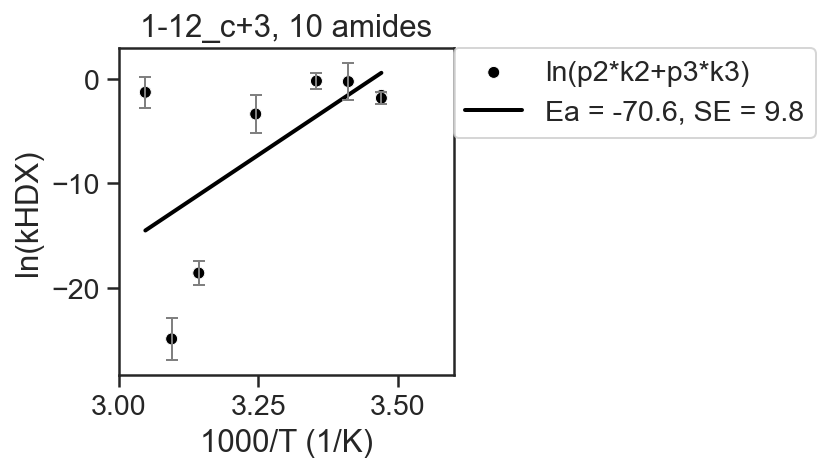

Intercept    3.036923
y           -0.157238
dtype: float64
-5.77157716447623


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


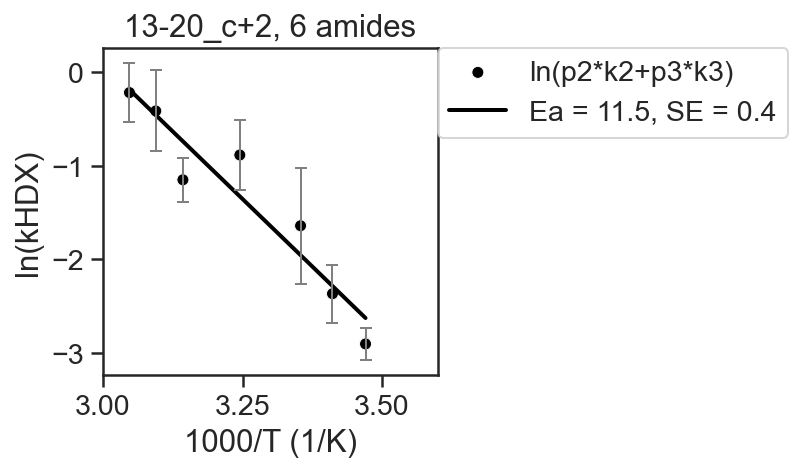

Intercept    3.229965
y           -0.023595
dtype: float64
-0.3963772340813195


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


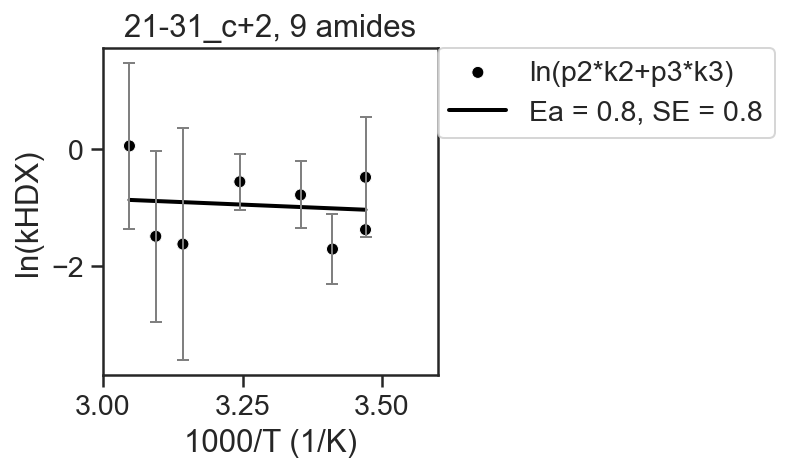

Intercept    3.555095
y            0.134227
dtype: float64
4.633643638513426


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


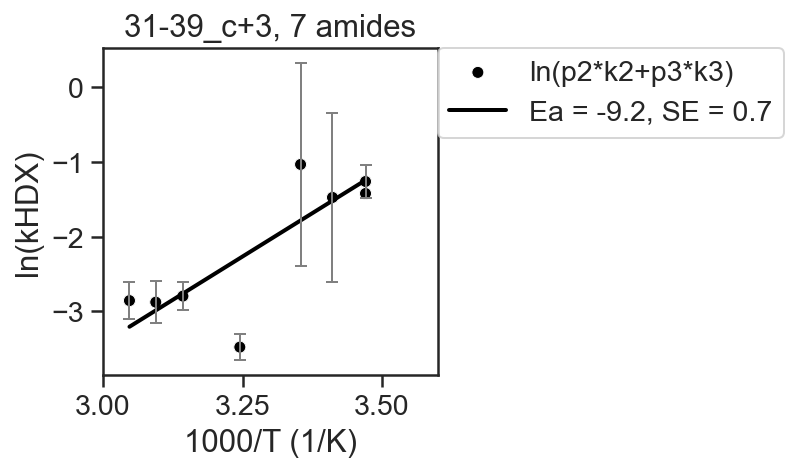

Exception ignored in: <function tqdm.__del__ at 0x7fdc7175d280>
Traceback (most recent call last):
  File "/Users/asoma/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/Users/asoma/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x7fdc7175d280>
Traceback (most recent call last):
  File "/Users/asoma/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/Users/asoma/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x7fdc7175d280>
Traceback (most recent call last):
  File "/Users/asoma/opt/anaconda3/lib/python

Intercept    3.138912
y           -0.091297
dtype: float64
-0.9542839923876772


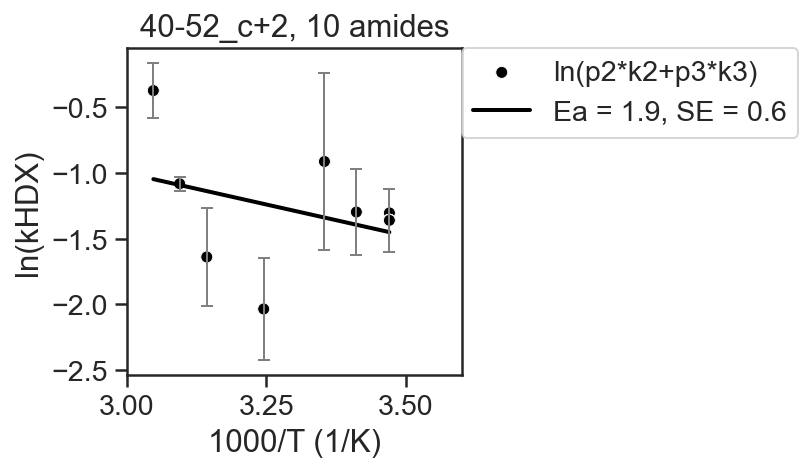

Intercept    2.427584
y           -0.190269
dtype: float64
-4.665663633845469


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


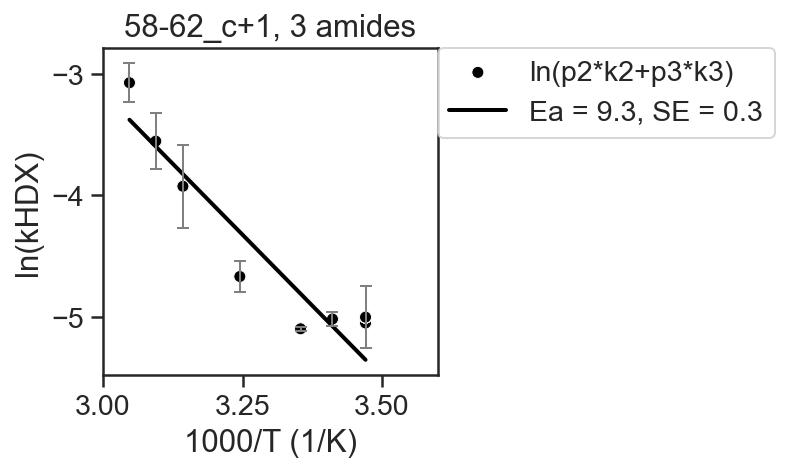

Intercept    2.879551
y           -0.230523
dtype: float64
-2.678574862385906


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


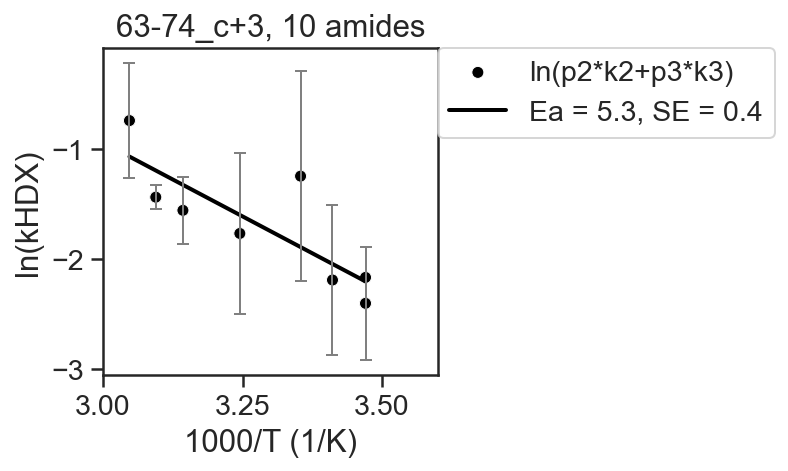

Intercept    2.869217
y           -0.184898
dtype: float64
-4.118629399889542


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


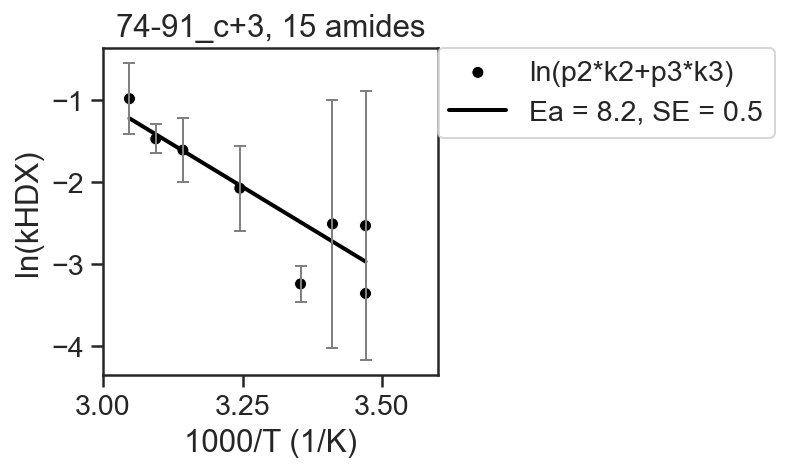

Intercept    3.066838
y           -0.129716
dtype: float64
-7.553190347400843


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


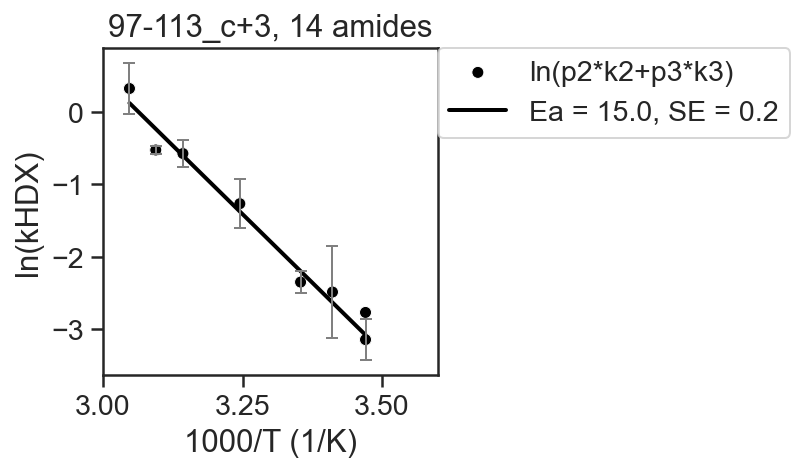

Intercept    3.036238
y           -0.128172
dtype: float64
-7.577618417739299


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


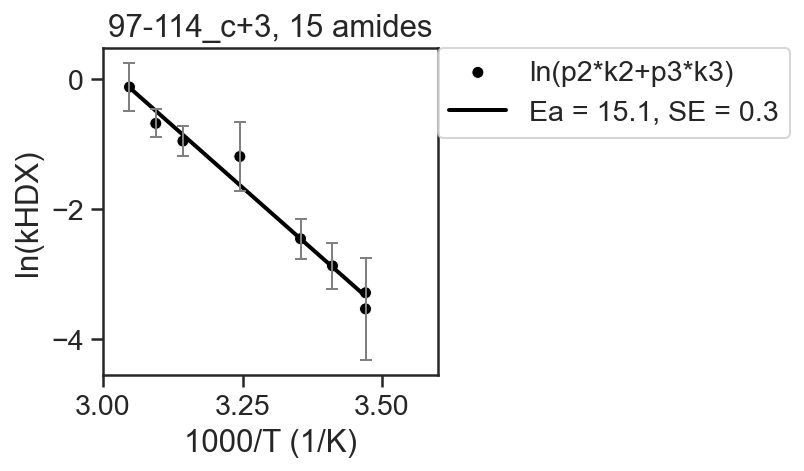

Intercept    2.213199
y           -0.385187
dtype: float64
-1.590948093156347


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


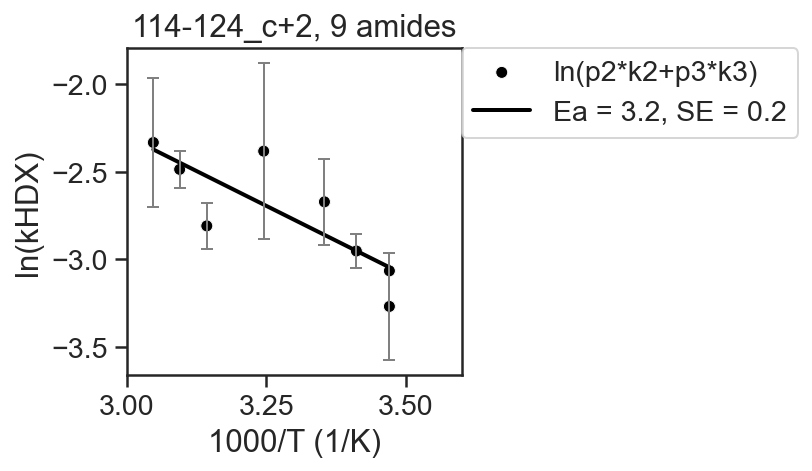

Intercept    3.000727
y           -0.201983
dtype: float64
-3.3432841216868505


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


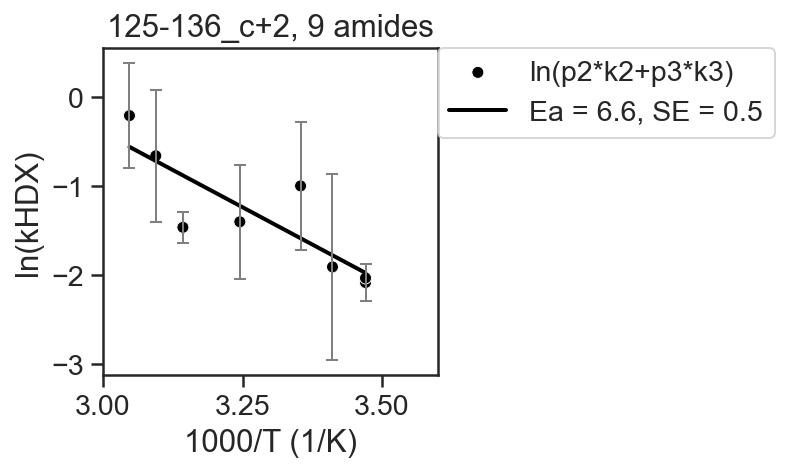

Intercept    3.026458
y           -0.131060
dtype: float64
-7.2552413864294705


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


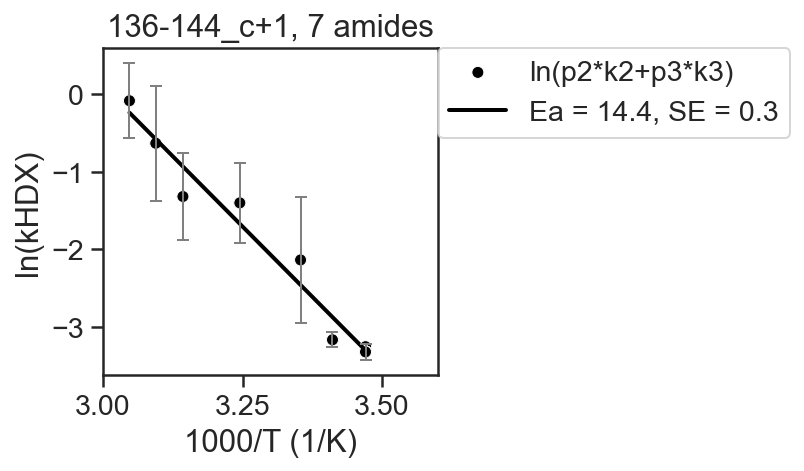

Intercept    3.222325
y           -0.009983
dtype: float64
-0.9174375926675635


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


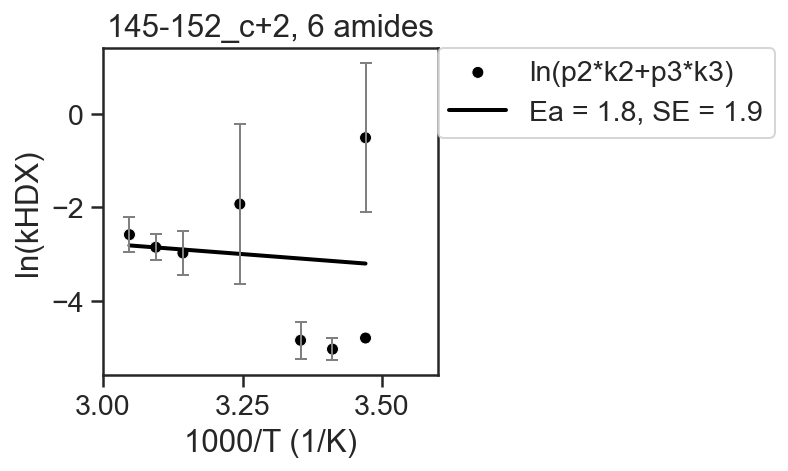

Intercept    3.040165
y           -0.146040
dtype: float64
-5.366676666706572


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


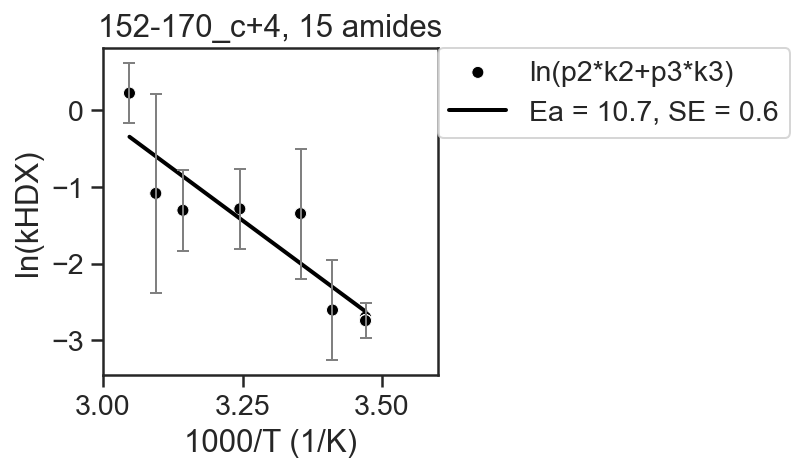

Intercept    3.411746
y            0.079683
dtype: float64
1.7430851230201871


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


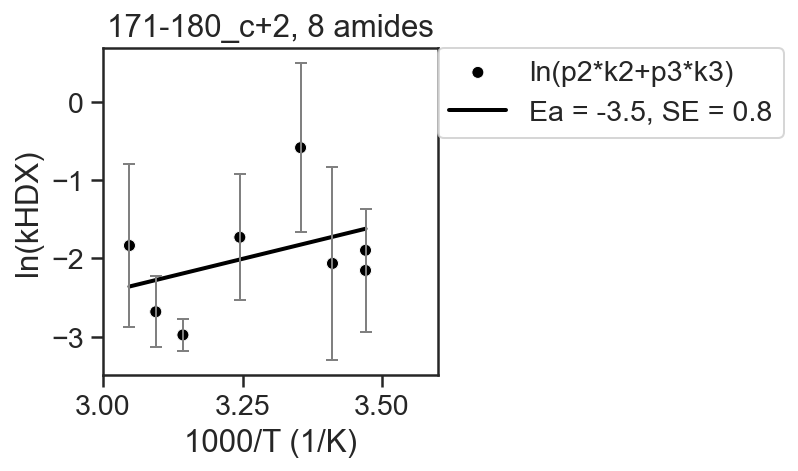

Intercept    3.475774
y            0.106957
dtype: float64
4.222232643529948


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


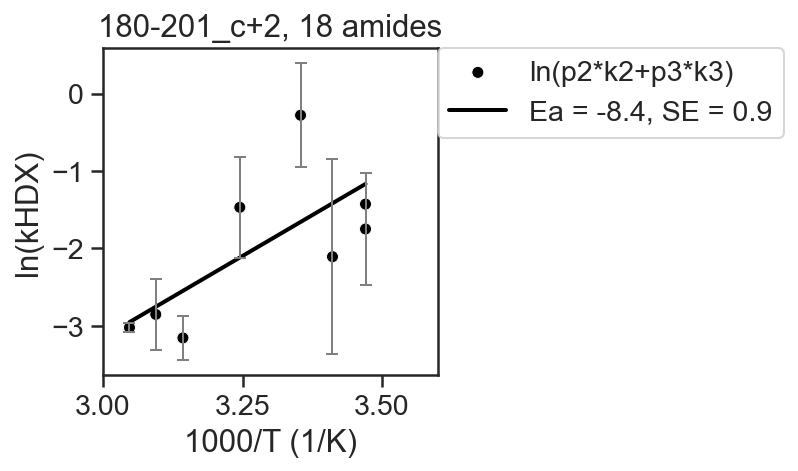

Intercept    3.095740
y           -0.073395
dtype: float64
-9.173722874658736


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


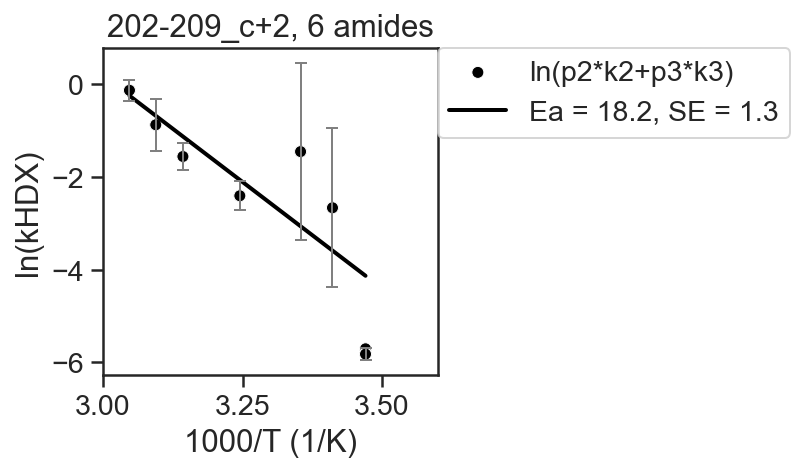

Intercept    2.991339
y           -0.096673
dtype: float64
-10.288818137380185


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


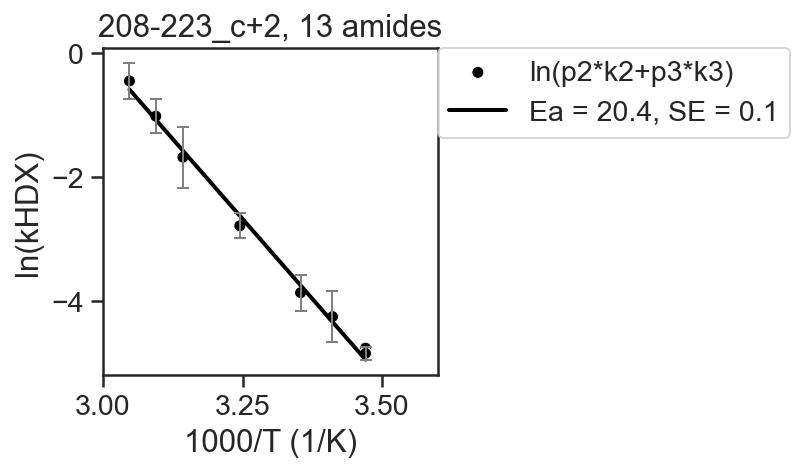

Intercept    3.179329
y           -0.266289
dtype: float64
-2.1473852916369407


/var/folders/dm/tttfryln0dxdfh6f78d7rw4c0000gn/T/ipykernel_85542/1978514189.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(X, intercept + slope*X, 'r', label=('Ea = %2.1f, SE = %2.1f' % (Ea, SE_R)), color = color )


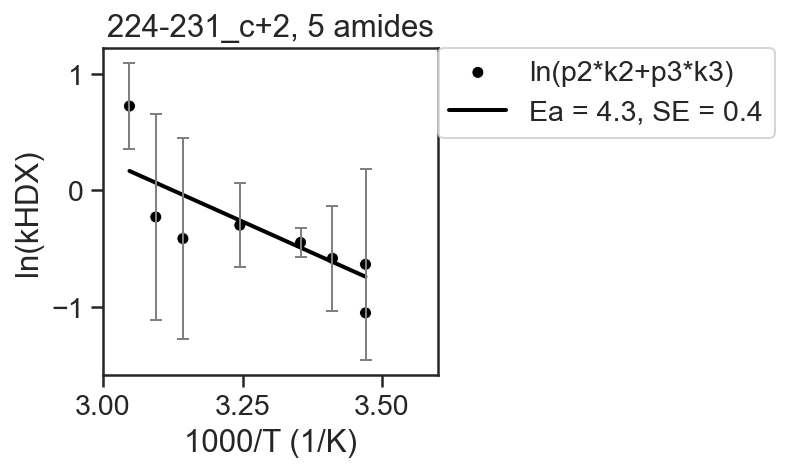

In [131]:
# Plotting for data

for set1, setDF in WT_minimal2.groupby(by = ['start','end','charge']):
    start, end, charge = set1
    ylim=setDF['NH-total'].iloc[0]
    #ylim=float(setDF['NH-total'].iloc(0))
    plt.figure(figsize=(3,3))
    sns.scatterplot(data = setDF, x='1000/T (K)',y='ln(p2*k2+p3*k3)_NHobs', hue='temperature', palette = temp2colorblack, legend = False, label = 'ln(p2*k2+p3*k3)')
    Ea1_temp = linfit(setDF, x = '1000/T (K)', y = 'ln(p2*k2+p3*k3)_NHobs', color = 'black', error = 'ln(p2*k2+p3*k3)_NHobs_std')
    sns.set_style("ticks")    
    figname1 = 'WT_Ea_3/%s-%s_c+%s_n_Ea.png' % (int(set1[0]), int(set1[1]), int(set1[2]))
    plt.title('%s-%s_c+%s, %s amides' % (int(set1[0]), int(set1[1]), int(set1[2]), ylim))
    plt.savefig(figname1, bbox_inches='tight')
    plt.show();

Intercept    3.315850
y            0.010561
dtype: float64
27.425515218441355
       slope         Ea       r^2        SE
0  27.425515 -54.494499  0.289644  8.408903


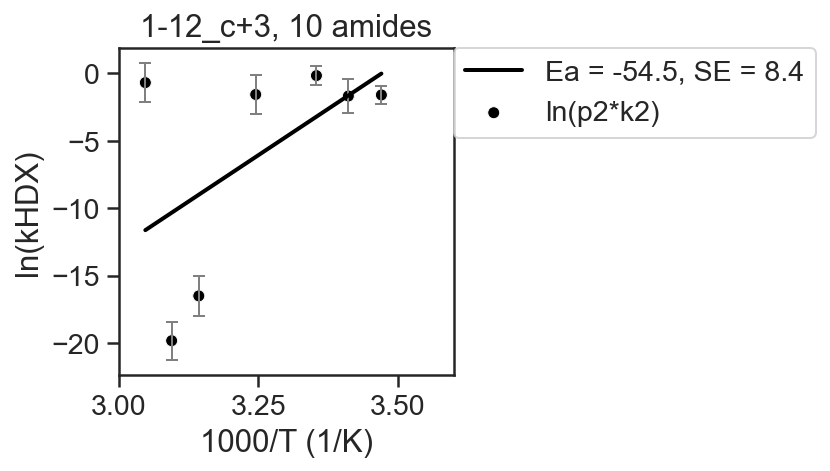

Intercept    2.946244
y           -0.153454
dtype: float64
-6.301912773211292
      slope         Ea       r^2        SE
0 -6.301913  12.521901  0.967053  0.227737


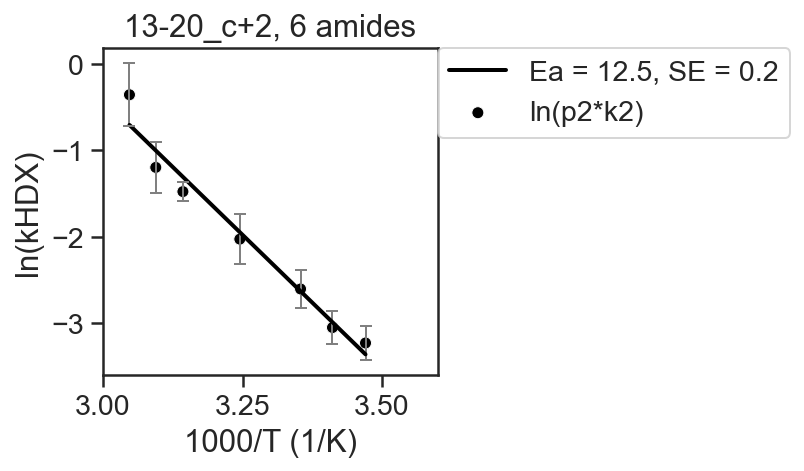

Intercept    3.139695
y           -0.120844
dtype: float64
-4.7537946628450225
      slope       Ea       r^2        SE
0 -4.753795  9.44579  0.574469  0.801035


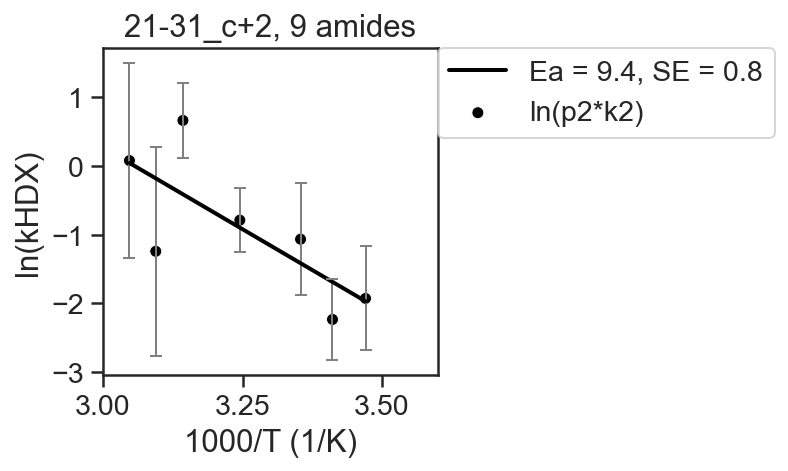

Intercept    3.252966
y            0.000200
dtype: float64
0.007423584463096805
      slope        Ea       r^2        SE
0  0.007424 -0.014751  0.000001  1.192297


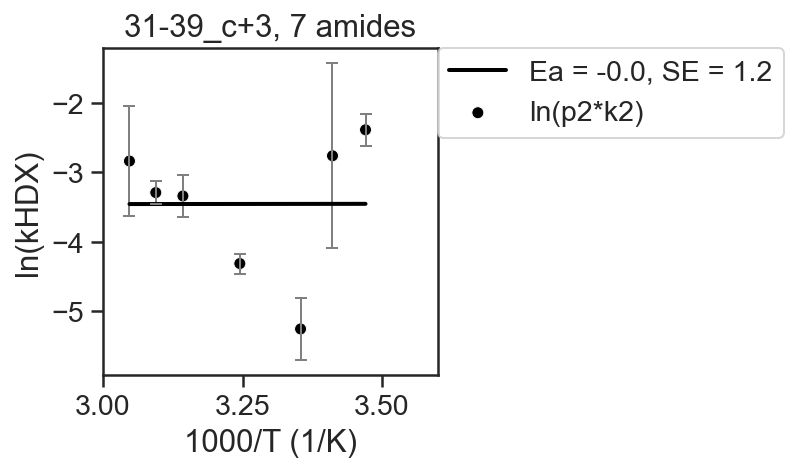

Intercept    2.985321
y           -0.147541
dtype: float64
-0.7615955529037333
      slope       Ea       r^2        SE
0 -0.761596  1.51329  0.112367  0.419085


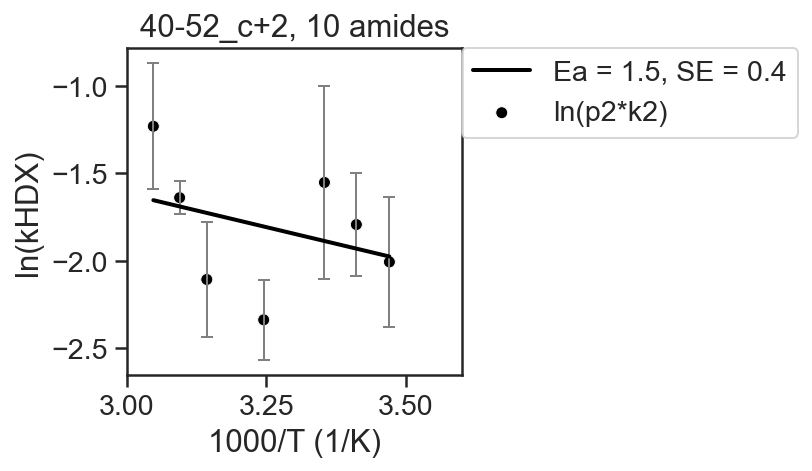

Intercept    3.030217
y           -0.005583
dtype: float64
-168.80744108157867
        slope          Ea       r^2        SE
0 -168.807441  335.420385  0.942457  8.166478


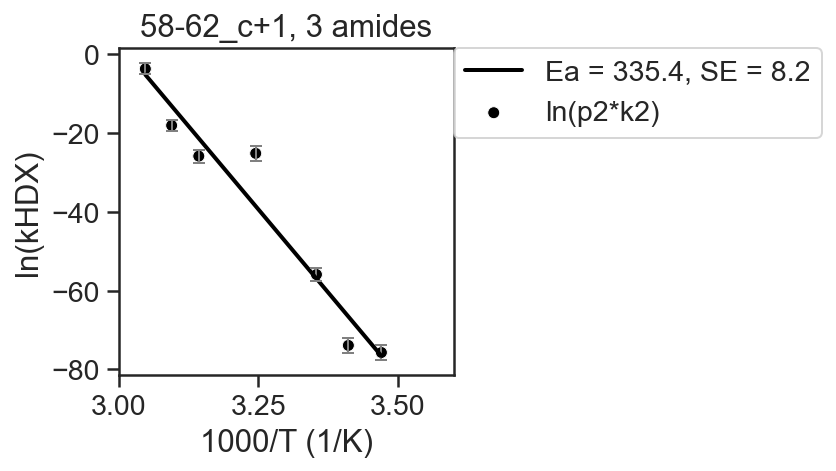

Intercept    2.809790
y           -0.192537
dtype: float64
-4.797292869916787
      slope        Ea       r^2        SE
0 -4.797293  9.532221  0.923656  0.270027


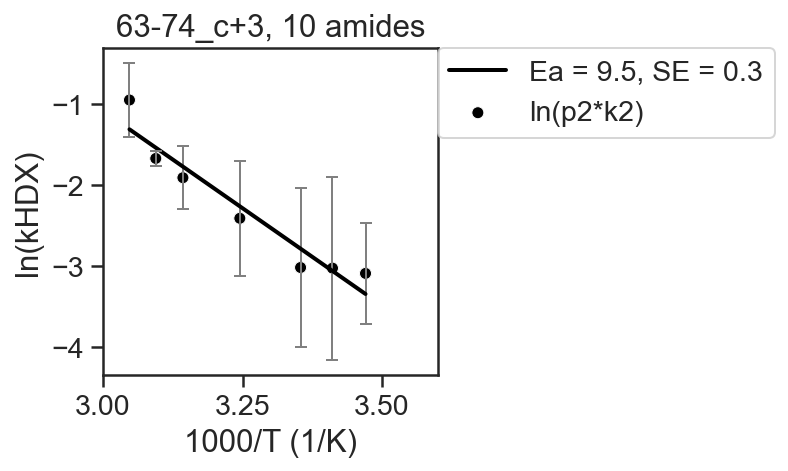

Intercept    2.774883
y           -0.142210
dtype: float64
-6.517557960783841
      slope         Ea       r^2        SE
0 -6.517558  12.950388  0.926859  0.358458


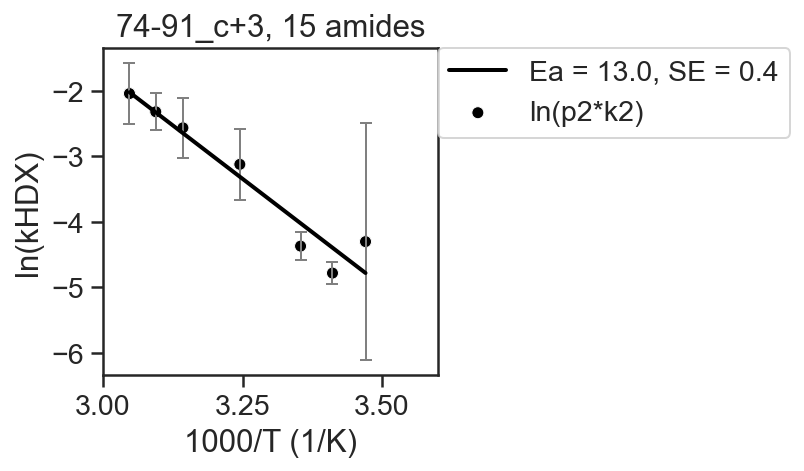

Intercept    2.961100
y           -0.112881
dtype: float64
-8.66127780881501
      slope         Ea       r^2        SE
0 -8.661278  17.209959  0.977692  0.256145


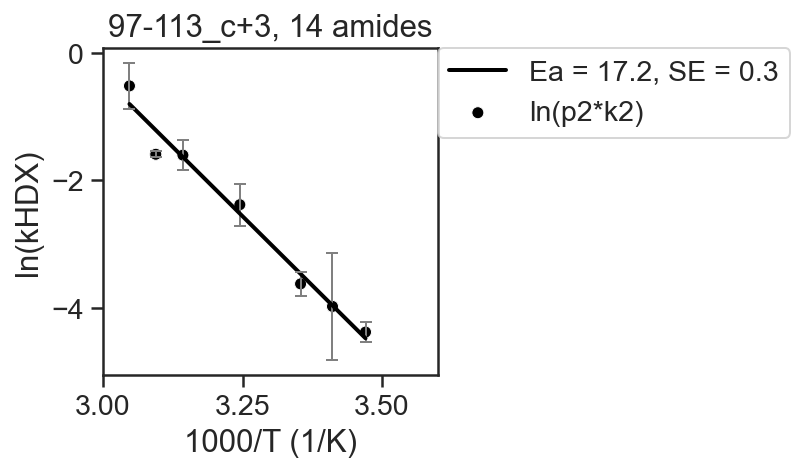

Intercept    3.179266
y           -0.035436
dtype: float64
-2.20727791190607
      slope        Ea       r^2        SE
0 -2.207278  4.385861  0.078218  1.483534


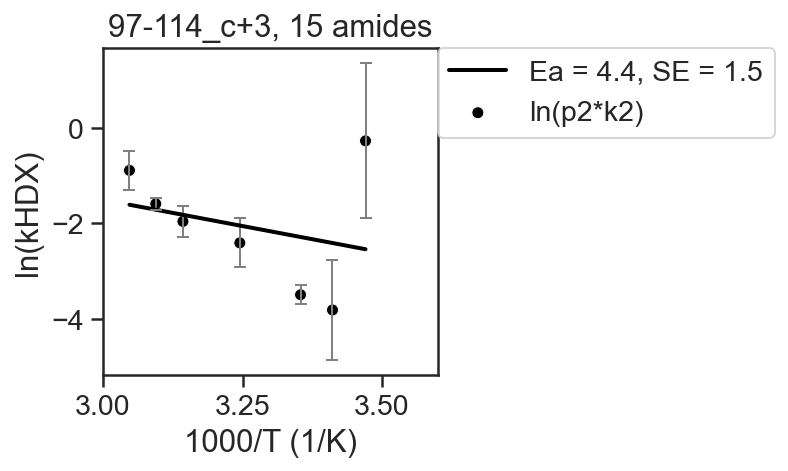

Intercept    2.350690
y           -0.276901
dtype: float64
-3.3650721719196923
      slope        Ea       r^2        SE
0 -3.365072  6.686398  0.931793  0.178249


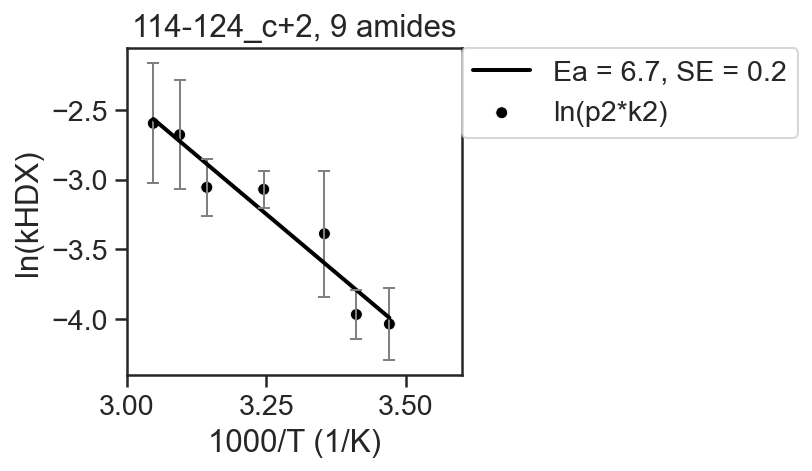

Intercept    2.833721
y           -0.165560
dtype: float64
-3.755422953782794
      slope        Ea       r^2        SE
0 -3.755423  7.462025  0.621746  0.573486


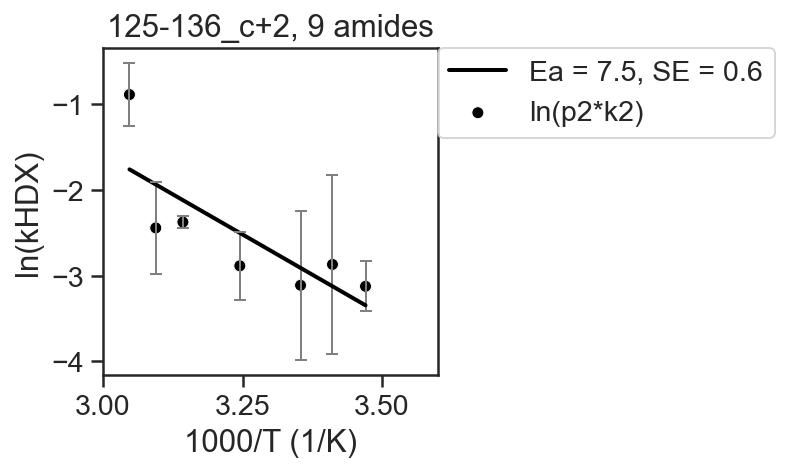

Intercept    2.921721
y           -0.166367
dtype: float64
-5.950425339441019
      slope         Ea       r^2        SE
0 -5.950425  11.823495  0.989954  0.117358


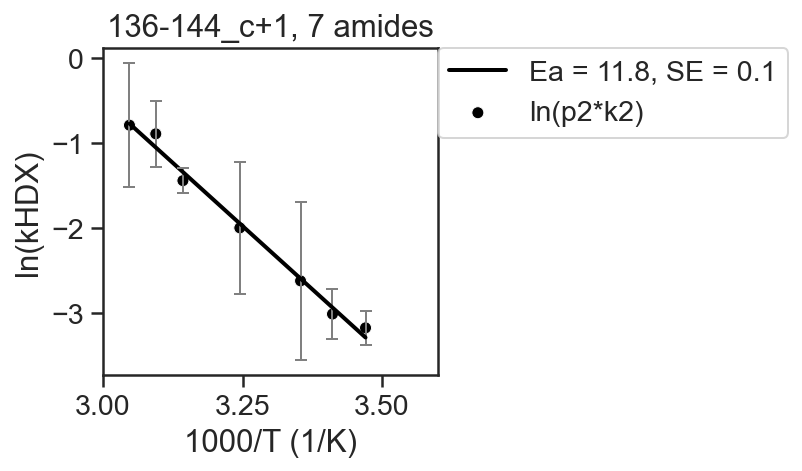

Intercept    3.366129
y            0.032187
dtype: float64
1.887509634192918
     slope        Ea       r^2        SE
0  1.88751 -3.750482  0.060754  1.453017


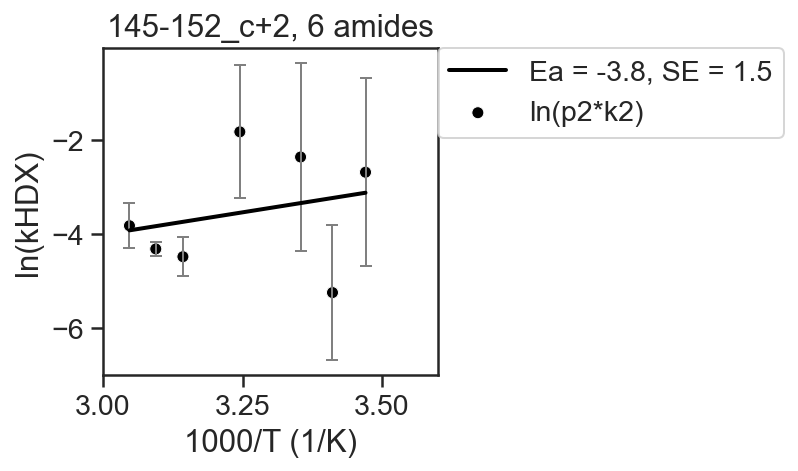

Intercept    3.027969
y           -0.139052
dtype: float64
-6.091283181908262
      slope        Ea       r^2        SE
0 -6.091283  12.10338  0.847007  0.506852


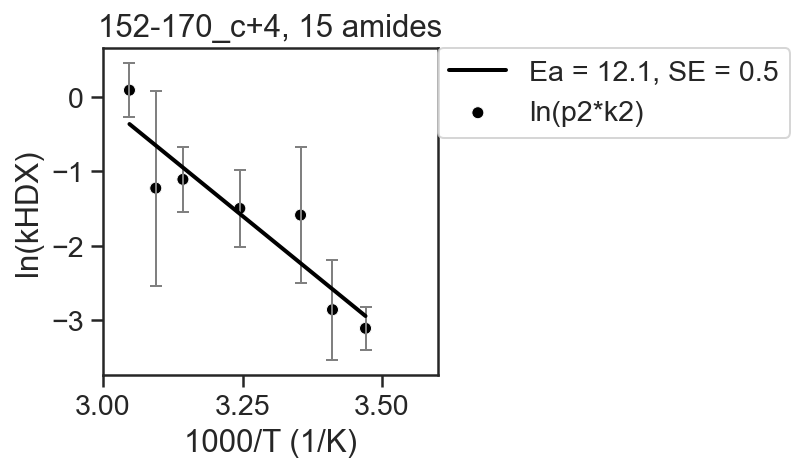

Intercept    3.523883
y            0.087357
dtype: float64
2.4270556590420136
      slope       Ea      r^2        SE
0  2.427056 -4.82256  0.21202  0.916068


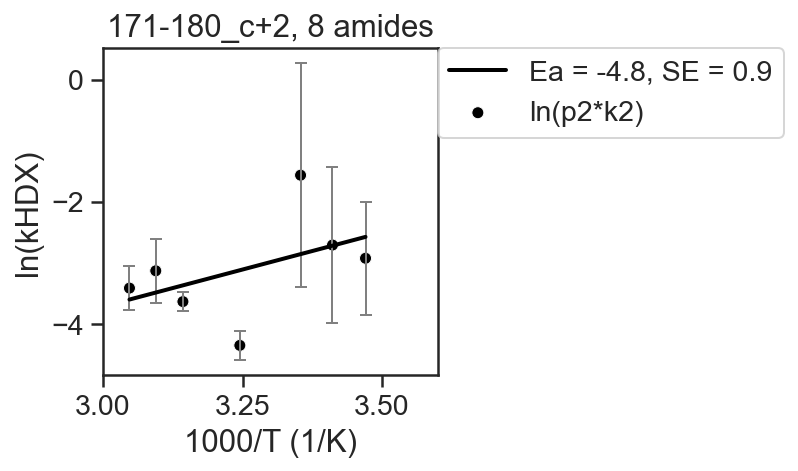

Intercept    2.862582
y           -0.191109
dtype: float64
-4.432775548768188
      slope        Ea       r^2        SE
0 -4.432776  8.807925  0.847145  0.368652


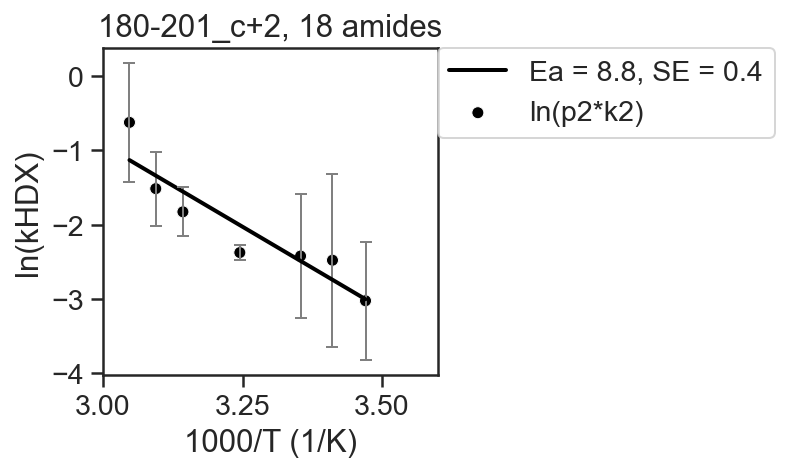

Intercept    3.090644
y           -0.067291
dtype: float64
-7.612389331158406
      slope         Ea       r^2        SE
0 -7.612389  15.125818  0.512245  1.454329


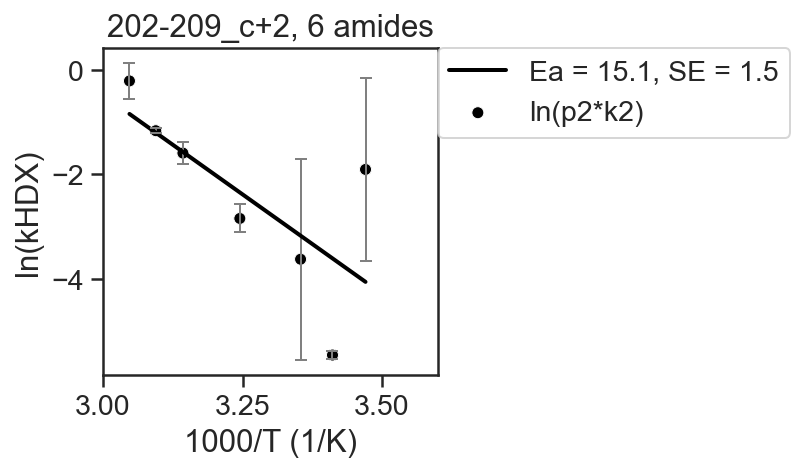

Intercept    2.989125
y           -0.091686
dtype: float64
-9.8048809450989
      slope         Ea      r^2        SE
0 -9.804881  19.482298  0.89897  0.643538


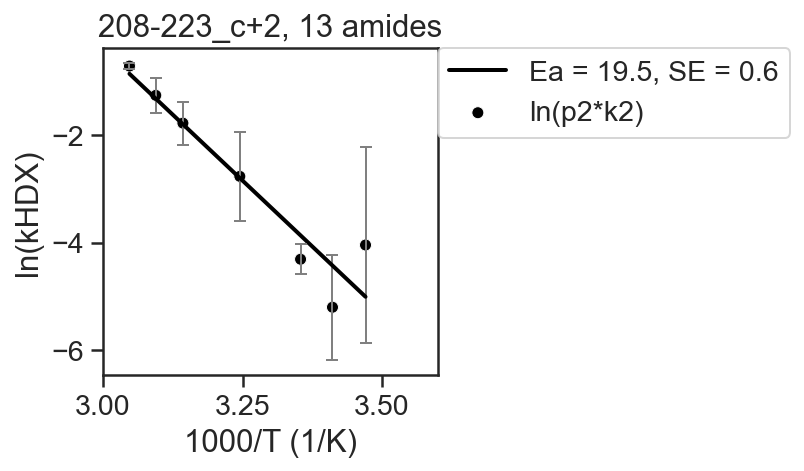

Intercept    3.20143
y           -0.15895
dtype: float64
-3.7692574410032447
      slope        Ea       r^2        SE
0 -3.769257  7.489515  0.599123  0.603647


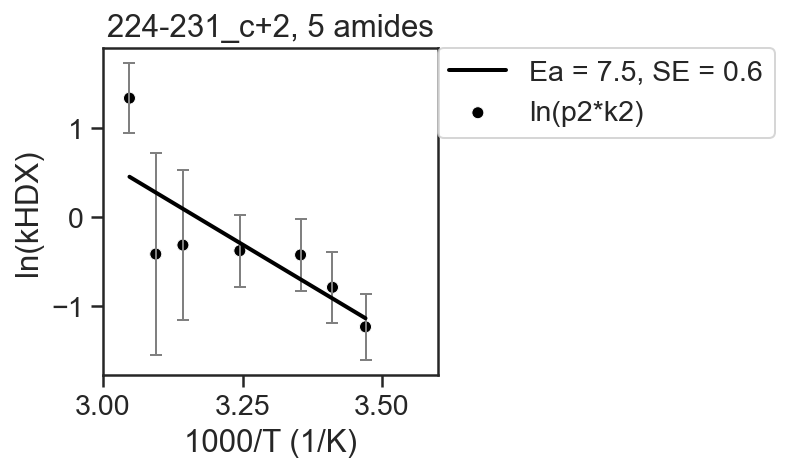

In [47]:
# Plotting

for set1, setDF in WT_minimal2.groupby(by = ['start','end','charge']):
    start, end, charge = set1
    ylim=setDF['NH-total'].iloc[0]
    #ylim=float(setDF['NH-total'].iloc(0))
    plt.figure(figsize=(3,3))
    sns.scatterplot(data = setDF, x='1000/T (K)',y='ln(p2*k2)_NHtotal', hue='temperature', palette = temp2colorblack, legend = False, label = 'ln(p2*k2)')
    Ea1_temp = linfit(setDF, x = '1000/T (K)', y = 'ln(p2*k2)_NHtotal', color = 'black', error = 'ln(p2*k2)_NHtotal_std')
    print(Ea1_temp)
    sns.set_style("ticks")    
    figname1 = 'WT_Ea_3/%s-%s_c+%s_n_Ea.png' % (int(set1[0]), int(set1[1]), int(set1[2]))
    plt.title('%s-%s_c+%s, %s amides' % (int(set1[0]), int(set1[1]), int(set1[2]), ylim))
    plt.savefig(figname1, bbox_inches='tight')
    plt.show();

Intercept    3.275435
y            0.000721
dtype: float64
8.541895277029587
      slope         Ea       r^2         SE
0  8.541895 -16.972746  0.006155  21.250204


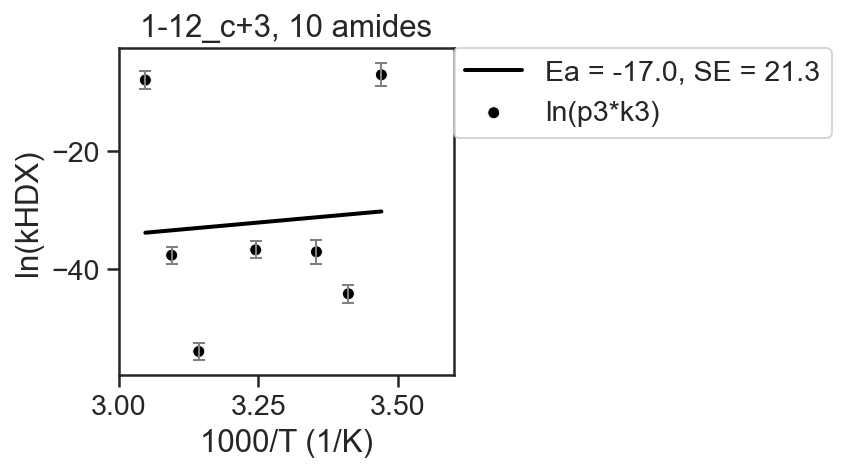

Intercept    3.974163
y            0.121822
dtype: float64
6.804100439993098
    slope         Ea       r^2        SE
0  6.8041 -13.519748  0.828891  0.605254


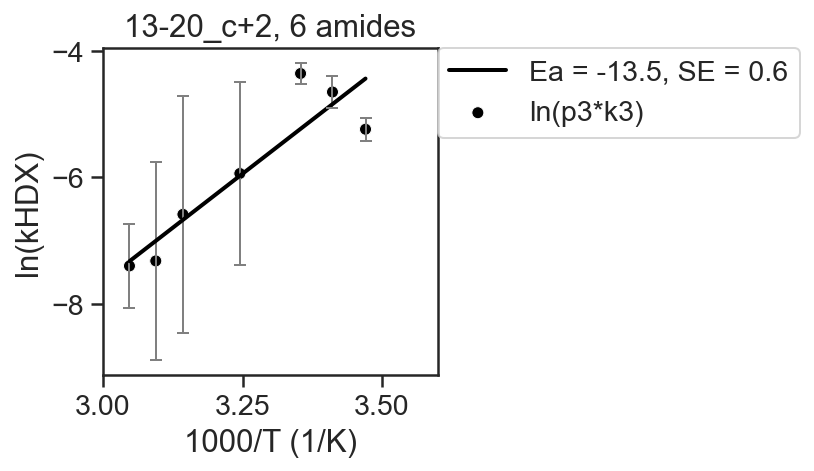

Intercept    3.381401
y            0.019600
dtype: float64
1.7976321885725557
      slope        Ea       r^2        SE
0  1.797632 -3.571895  0.035234  1.841653


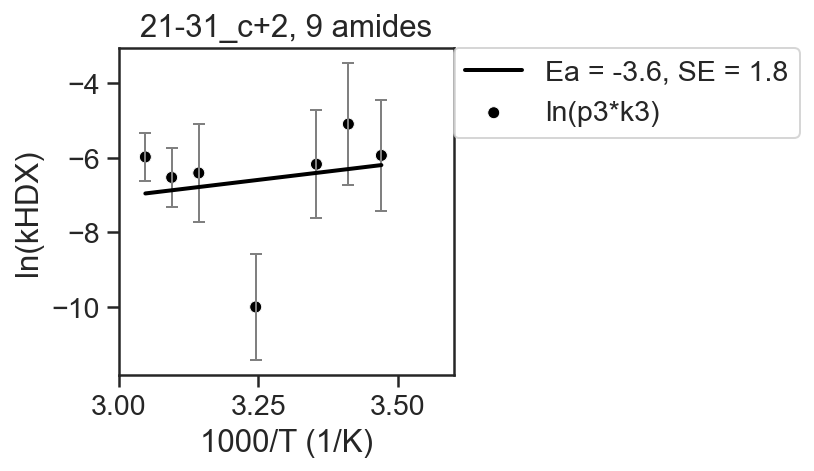

Intercept    2.748807
y           -0.080150
dtype: float64
-1.6022343541308417
      slope       Ea       r^2        SE
0 -1.602234  3.18364  0.128419  0.817232


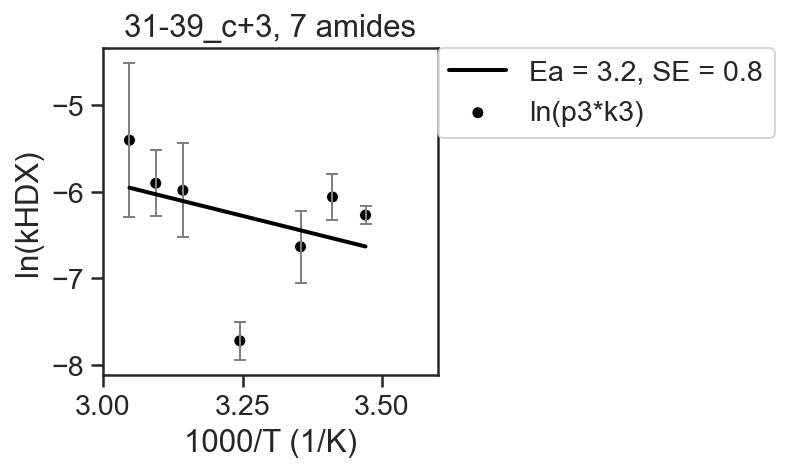

Intercept    3.378097
y            0.023158
dtype: float64
0.13842552955535278
      slope        Ea       r^2        SE
0  0.138426 -0.275052  0.003206  0.477904


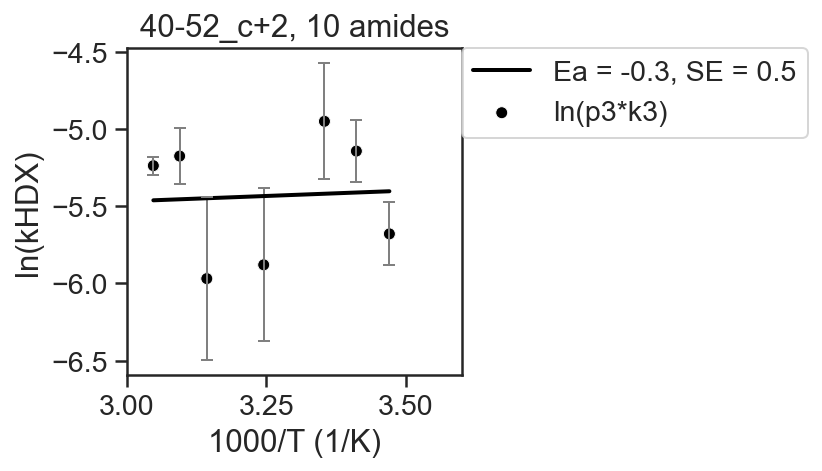

Intercept    2.736073
y           -0.092851
dtype: float64
-9.340182084108488
      slope         Ea       r^2        SE
0 -9.340182  18.558942  0.867246  0.715462


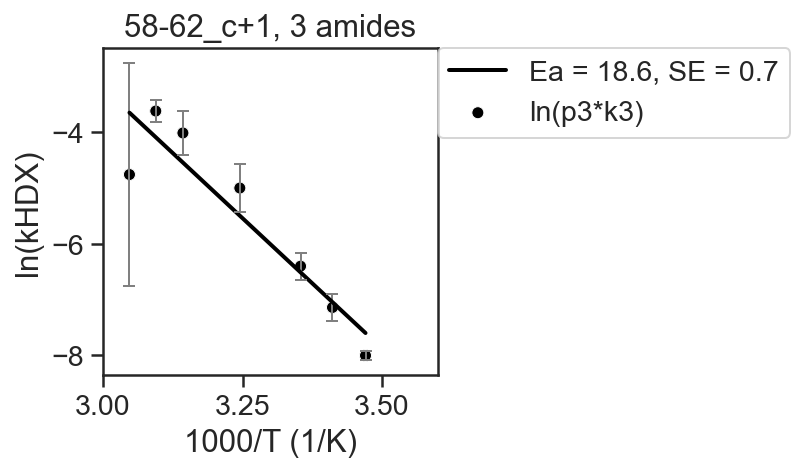

Intercept    4.708324
y            0.267879
dtype: float64
2.153903755553551
      slope        Ea       r^2        SE
0  2.153904 -4.279807  0.576985  0.361078


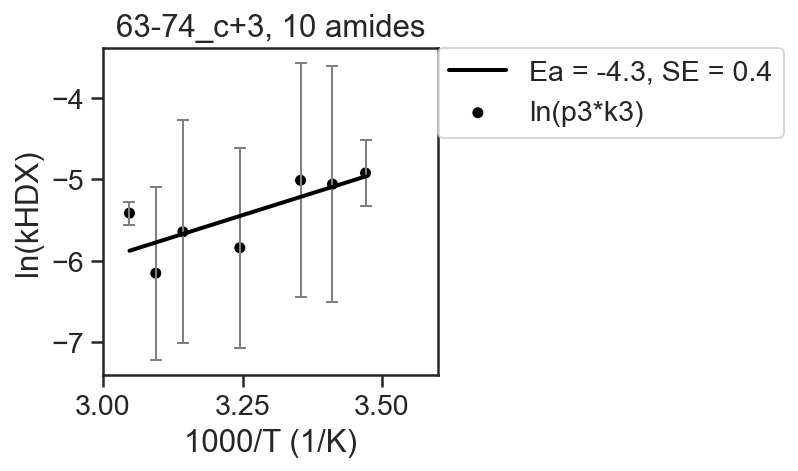

Intercept    3.157675
y           -0.012808
dtype: float64
-1.33695932926918
      slope        Ea       r^2        SE
0 -1.336959  2.656538  0.017124  1.983103


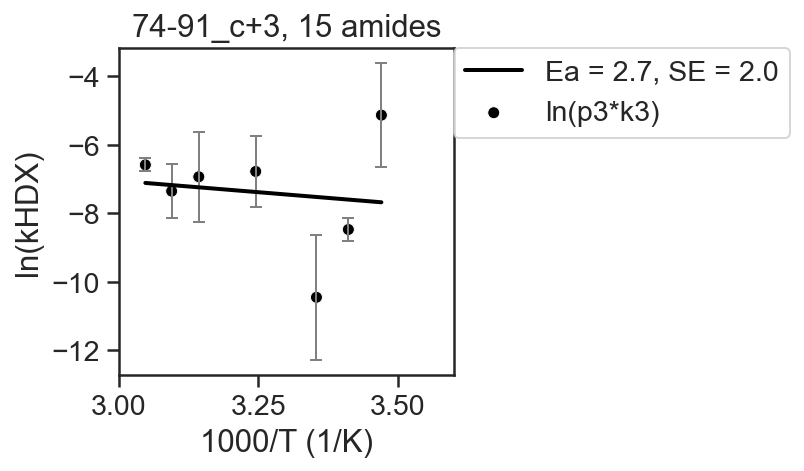

Intercept    3.270696
y            0.002560
dtype: float64
0.7974746206662922
      slope        Ea       r^2        SE
0  0.797475 -1.584582  0.002041  3.452094


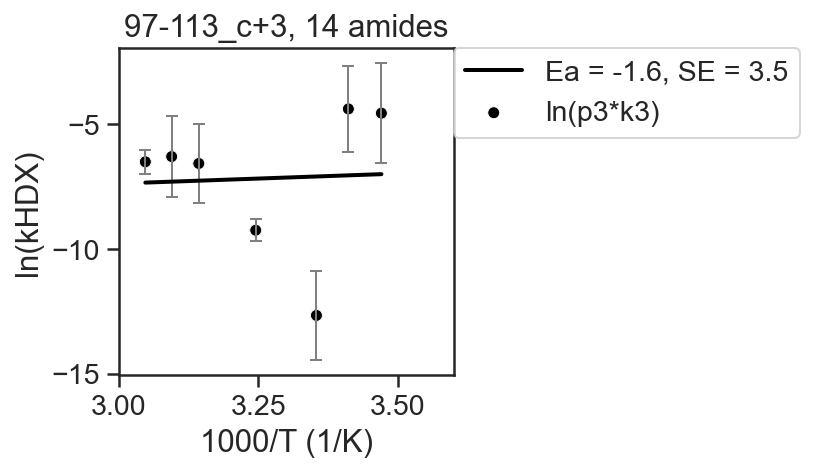

Intercept    3.522279
y            0.044567
dtype: float64
2.0889339429820413
      slope        Ea       r^2        SE
0  2.088934 -4.150712  0.093097  1.276489


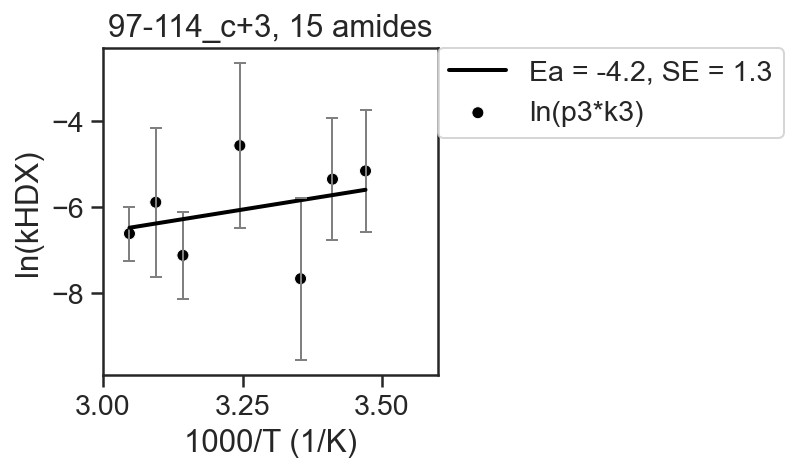

Intercept    2.632965
y           -0.104195
dtype: float64
-1.755548888678828
      slope        Ea       r^2        SE
0 -1.755549  3.488276  0.182919  0.726433


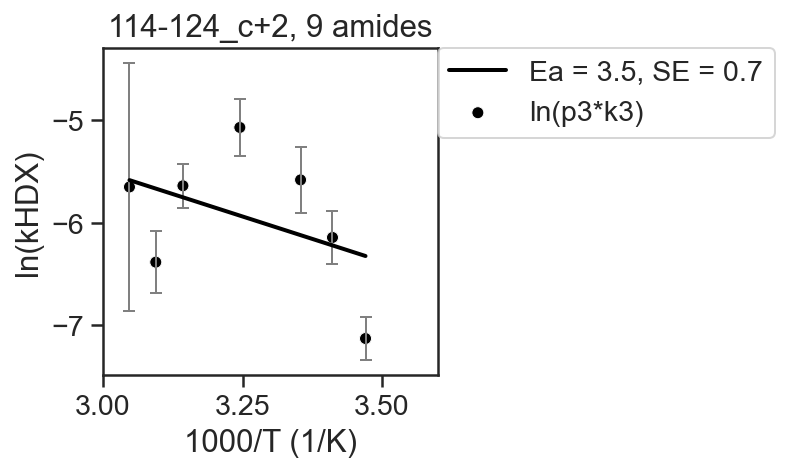

Intercept    3.515846
y            0.036650
dtype: float64
9.646825131140147
      slope         Ea       r^2      SE
0  9.646825 -19.168242  0.353552  2.5539


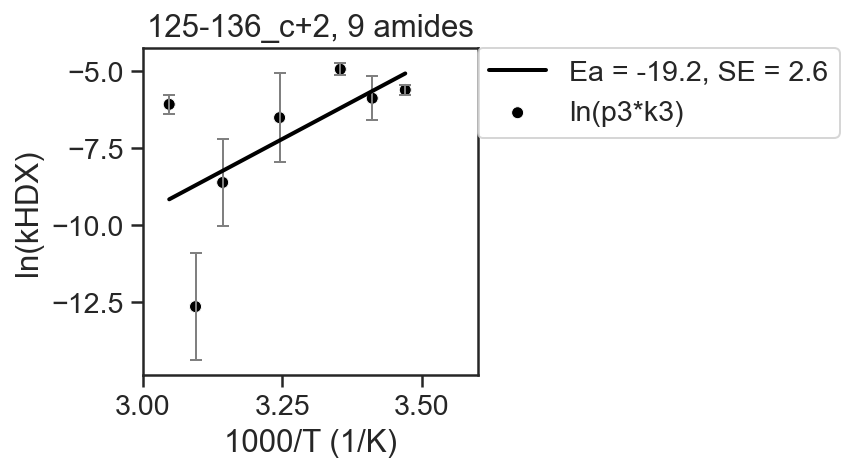

Intercept    4.005748
y            0.138345
dtype: float64
0.890185188991844
      slope        Ea       r^2       SE
0  0.890185 -1.768798  0.123153  0.46505


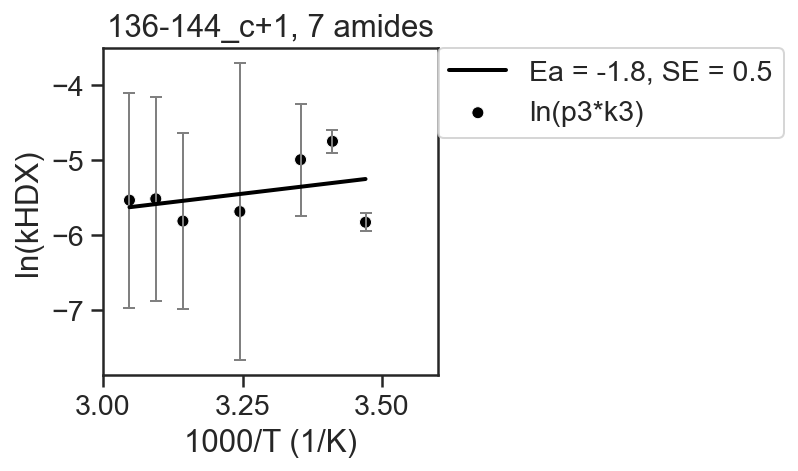

Intercept    3.436357
y            0.025168
dtype: float64
0.9986560767713731
      slope       Ea       r^2        SE
0  0.998656 -1.98433  0.025134  1.217689


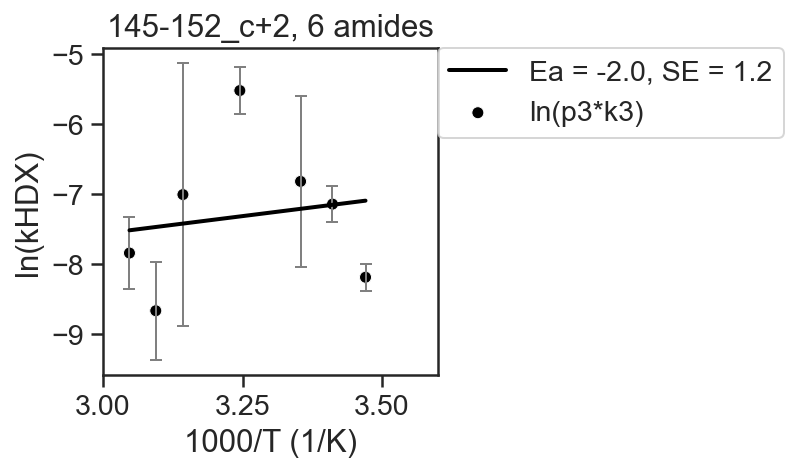

Intercept    2.334791
y           -0.163402
dtype: float64
-5.230258786441278
      slope         Ea       r^2        SE
0 -5.230259  10.392524  0.854633  0.422325


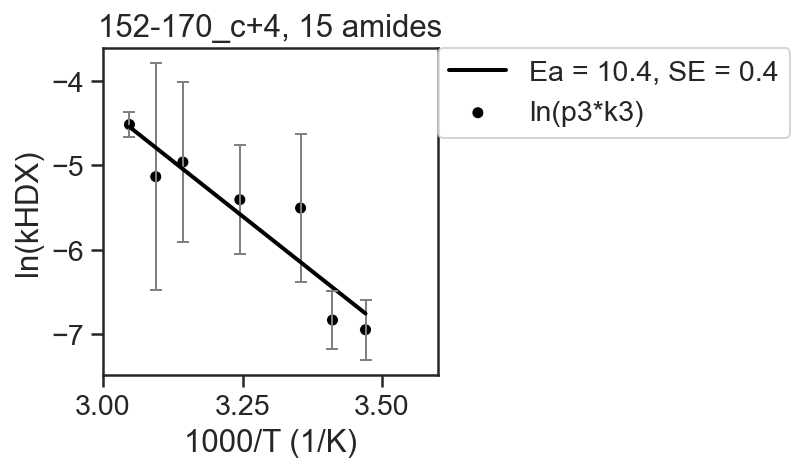

Intercept    3.258848
y            0.000957
dtype: float64
0.0912756804505502
      slope        Ea       r^2        SE
0  0.091276 -0.181365  0.000087  1.912194


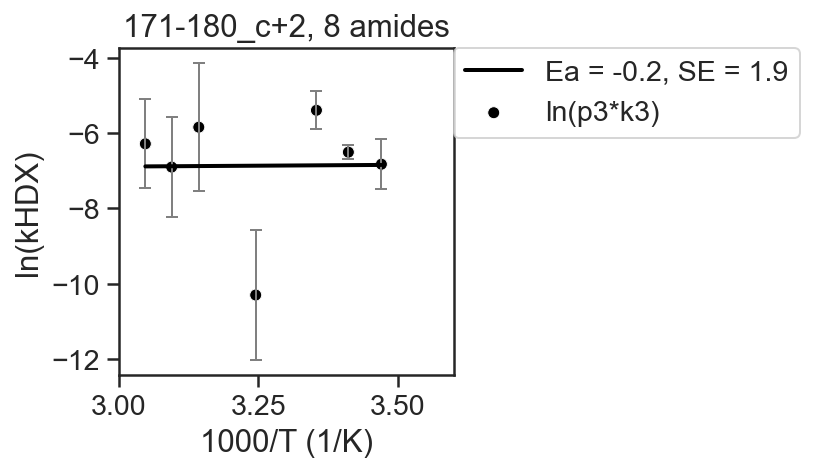

Intercept    3.561194
y            0.050459
dtype: float64
4.377600171022141
    slope        Ea       r^2        SE
0  4.3776 -8.698292  0.220888  1.609642


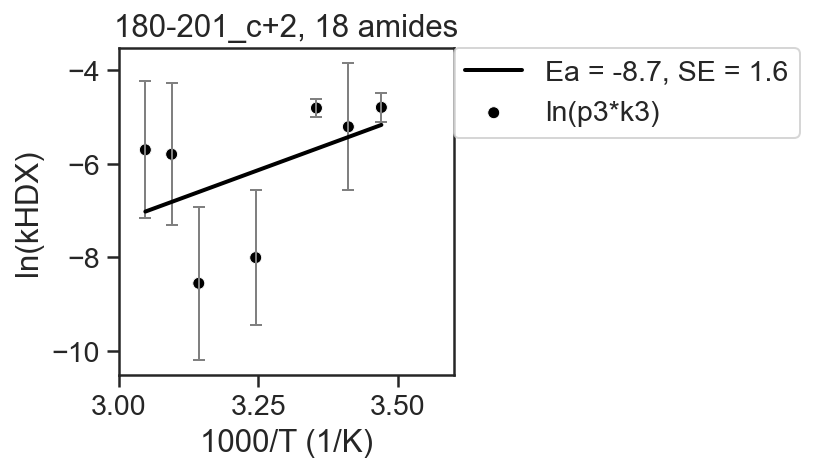

Intercept    3.533090
y            0.043793
dtype: float64
4.379678023939998
      slope       Ea       r^2       SE
0  4.379678 -8.70242  0.191801  1.76017


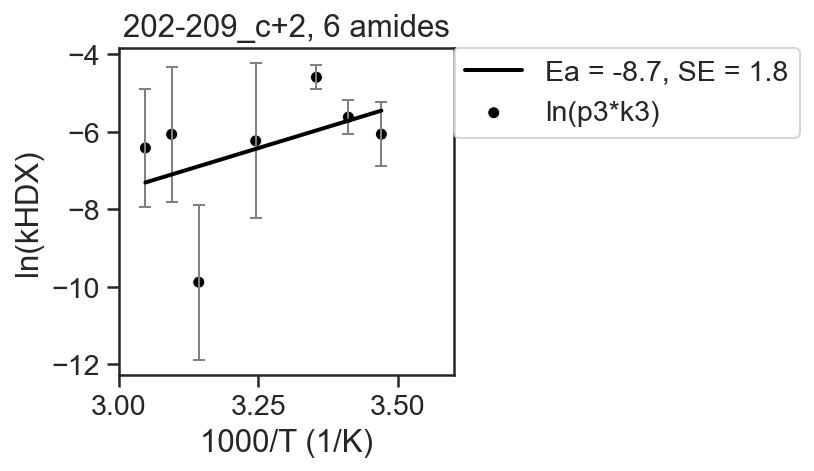

Intercept    2.435639
y           -0.158019
dtype: float64
-0.872003213932429
      slope       Ea       r^2        SE
0 -0.872003  1.73267  0.137793  0.427061


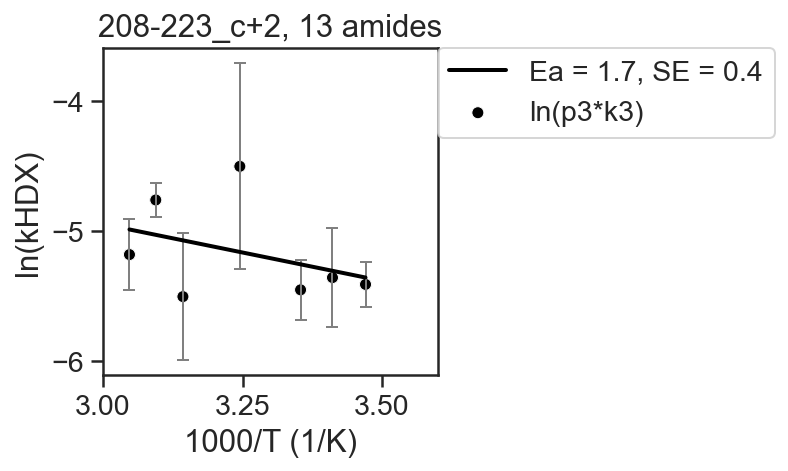

Intercept    3.357632
y            0.003354
dtype: float64
142.8357584829805
        slope          Ea       r^2         SE
0  142.835758 -283.814652  0.479111  29.158851


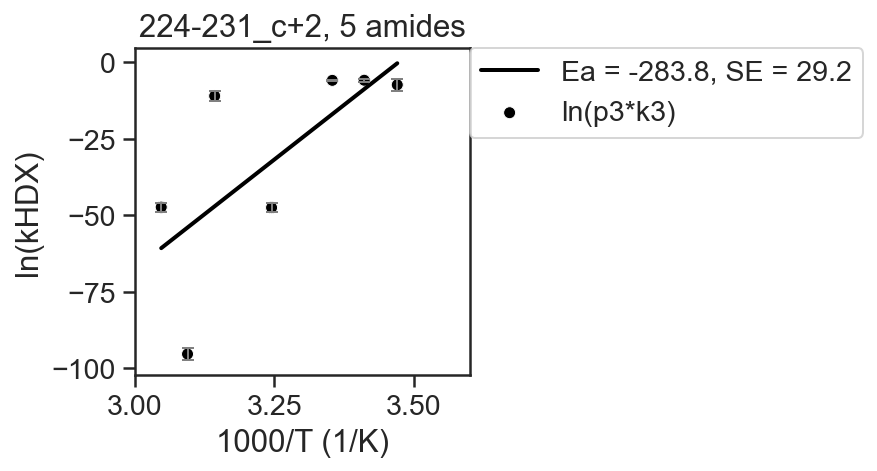

In [46]:
# Plotting

for set1, setDF in WT_minimal2.groupby(by = ['start','end','charge']):
    start, end, charge = set1
    ylim=setDF['NH-total'].iloc[0]
    #ylim=float(setDF['NH-total'].iloc(0))
    plt.figure(figsize=(3,3))
    sns.scatterplot(data = setDF, x='1000/T (K)',y='ln(p3*k3)_NHtotal', hue='temperature', palette = temp2colorblack, legend = False, label = 'ln(p3*k3)')
    Ea1_temp = linfit(setDF, x = '1000/T (K)', y = 'ln(p3*k3)_NHtotal', color = 'black', error = 'ln(p3*k3)_NHtotal_std')
    print(Ea1_temp)
    sns.set_style("ticks")    
    figname1 = 'WT_Ea_4/%s-%s_c+%s_n_Ea.png' % (int(set1[0]), int(set1[1]), int(set1[2]))
    plt.title('%s-%s_c+%s, %s amides' % (int(set1[0]), int(set1[1]), int(set1[2]), ylim))
    plt.savefig(figname1, bbox_inches='tight')
    plt.show();